# Optimization of phased array design using actual area metric
This notebook is used to find to collect data to find the optimal result of the transmission phased array to be in the Radar Echo Telescope (RET) experiment in Antarctica. Specifically, we are interested in finding the optimal depth of the phased array in the ice and steering angle of the electric field.

This notebook simulates many phased arrays with a variety of depth and steering angle parameters and then calculates a score for each of those designs which we will use to find the optimal design.

#### Notes
* Phased array is constructed using point-like dipoles.
* The verical coordinate z is oriented into the ice as positive.

#### Revision History
* Last revised 10-May-2022 by Leo Deer (deer.279@osu.edu).

# Intro

This notebook simulates many phased arrays with a variety of depth, inter-dipole spacing, and steering angle parameters and then calculates a score for each of those designs which we will use to find the optimal design.

#### Dipole Spacing
The inter-dipole spacing based on this function for the depth of the $l^{th}$ dipole,
<br>
$ D(l) = D_0 + d\cdot a\cdot (1-e^{-l/a})$
   * $D_0$ is the depth of the top dipole and is an optimized parameters
   * $a$ is a parameter that controls how exponential the interdipole spacing is and is an optimized parameters
   
This reduces to $ D(l) = D_0 + d\cdot l$ when $a>>n_{dipole}$ the total number of dipoles in the array. Thus,
 * $d$ as the interdipole spacing if all the dipoles were linear spaced out. We will call it "antenna seperation"

For our purposes $d$is always left at $\lambda$, the characteristic wavelength of the phased array dipoles. This exponential spacing was added to counter balance the effects of the non-linear refractive index of Antarctica which is specific to this problem. During my time with this project, we only wanted to study the linear spacing case, so $a$ is left at $100,000$

#### Steering angle
In order to steer the electirc field from the phased array at an angle $\phi$ in vacuum, we apply a phase factor to the signal of each dipole. The factor on the $l^{th}$ dipole source is, $e^{\left(-il(k\phi d) \right)}$
   - $k$ is the wavenumber of the antenna
   - $d$ is the inter-dipole seperation



### Scoring

The way I scored each simulation is based on a weighted area calculation. In all cases, we take advantage of the problems cylindrical symmetry and numerically integrate the area using the radial coordinate $r$. <br>
$$
\int_{\Omega}{w(r)da}
$$

We want the power output of the antenna to be concentrated near the surface of the ice because that's where an in-ice cascade of particles, caused by the neutrinos, will be. This way the transmitted signal will reflect off the in-ice cascade and be detected by the recieving antenna (RX). So we only want to calculate this weighted area in a region $\Omega$ where the $E-$field from the transmission array is a above a threshold. 

#### Thresholds
This threshold works in two ways. The first which I call $\verb"threshold_abs"$ checks if the electric field is above a certain numeric cutoff $C_{abs}$

$$C_{abs}<10\log_{10}{\left(E^2_{array}(r)\right)}$$

The other which I call the $\verb"threshold_dBd"$ sees if the power output of the phased array is higher than that of dipole by a certain amount $C_{dBd}$

$$C_{dBd}<10\log_{10}{\left(\frac{E^2_{array}(r)}{E^2_{dipole}(r)}\right)}$$

There is no theoretical level we should set the cutoffs $C_{abs}$ and $C_{dBd}$ at. Instead, after we've run all the simulations of the phased array at different parameters, we do the weighted area calculations using a variety of cutoff values and look at the results using different cutoffs.

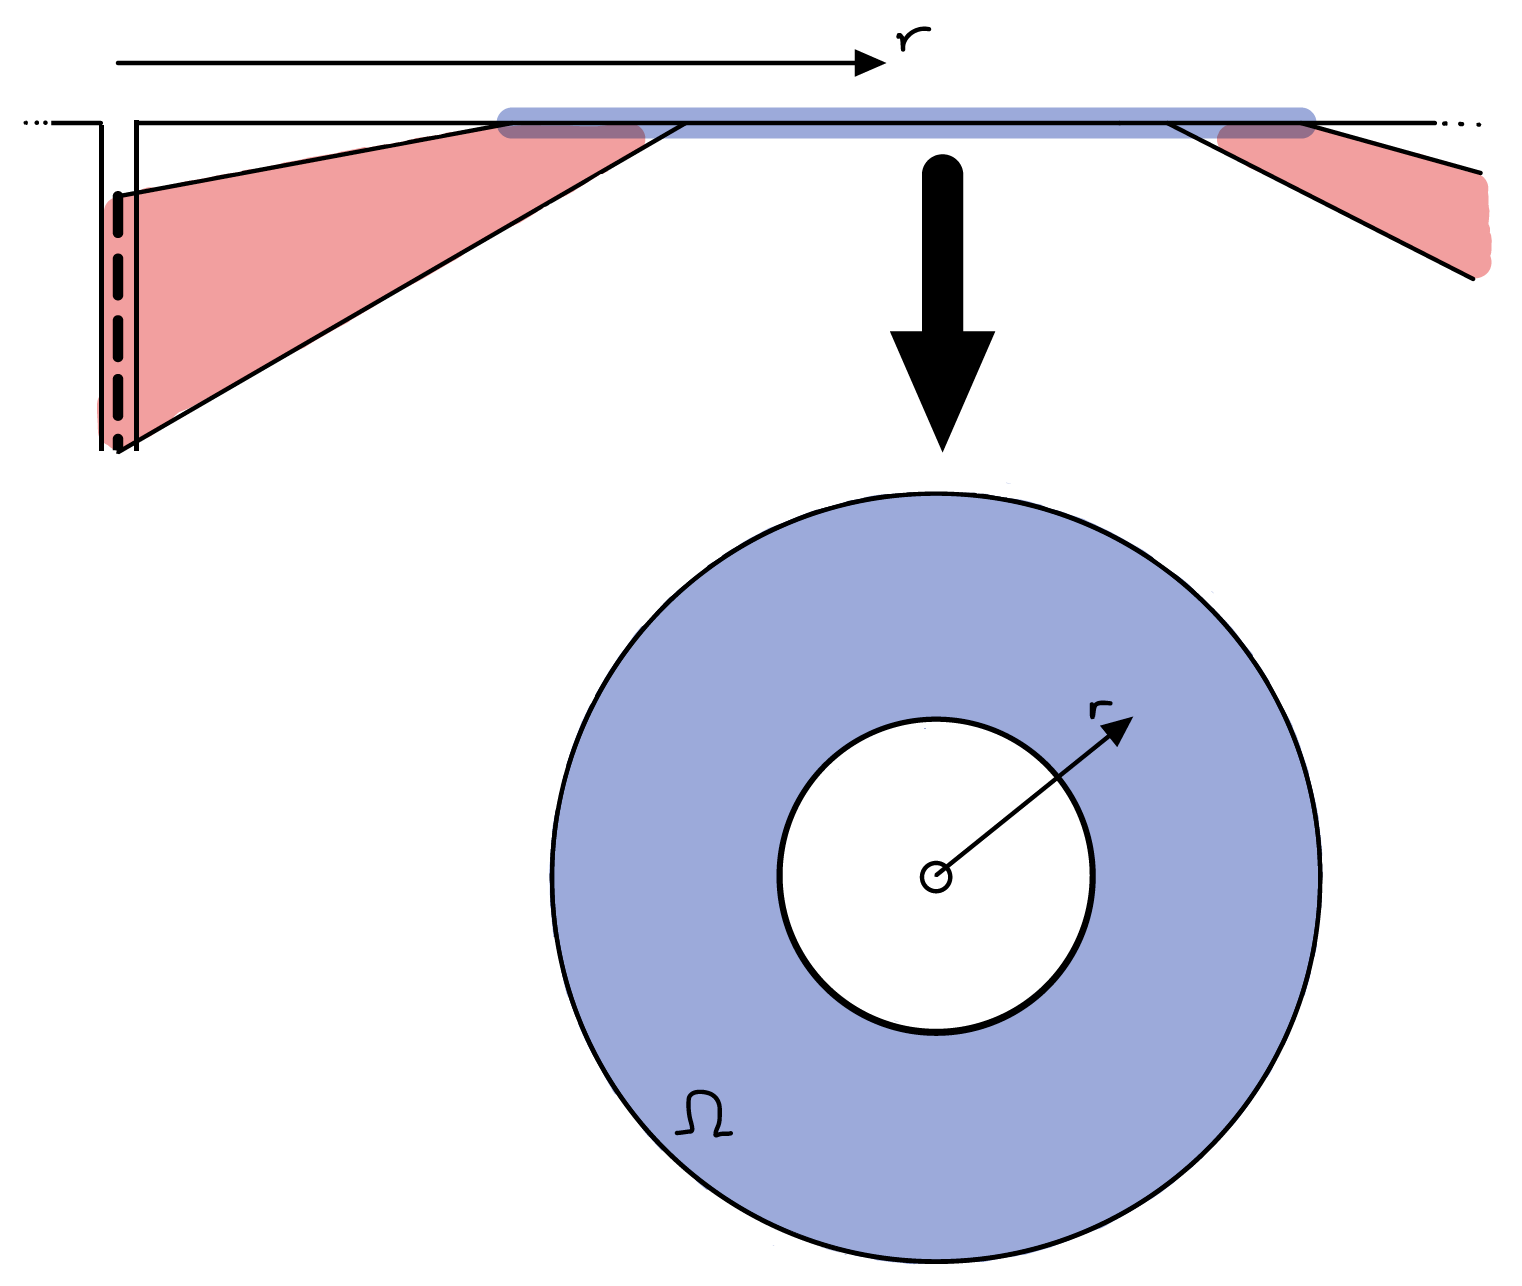

#### Weights

When it comes to determining the weights, we note that the experiment actually uses surface detectors to detect when and where there is a in-ice cascade. When the devices dectect an in-ice cascade a transmission signal from our phased array is sent out to reflect off the in-ice cascade. So, if this phased array signal is too far away from a surface detector than there may not be an in ice-cascade there.

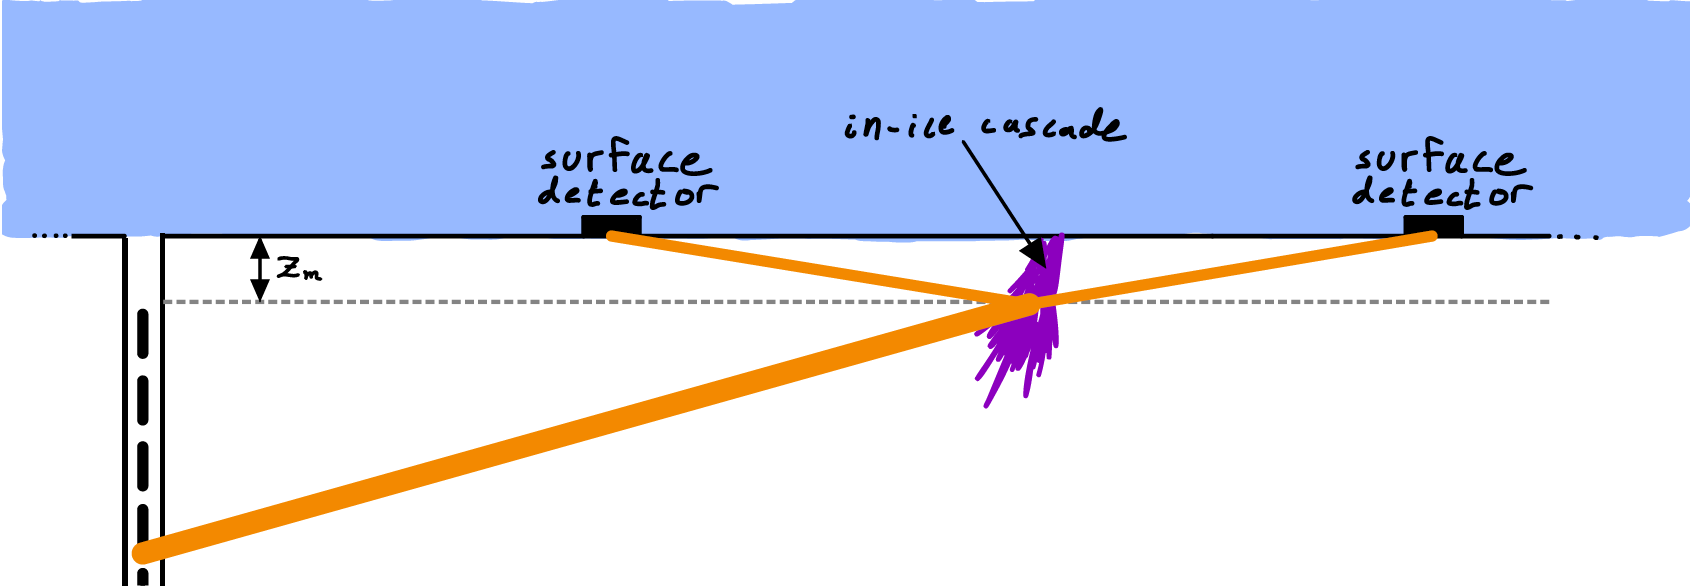

There are a set of detectors at a short range from the array and a set at a long range. We will calculate a weighted area four ways: 
* Ignoring the detectors and just calculate the actual area of $\Omega$
* Punish the area elements the further they are from the short range surface detector
* Same for the long range detector
* Punish the area elements the further they are from both surface detectors

The punishment weights $w(r)$ will be a factor of $1/\Delta{r}$ factor, where delta $\Delta{r}$ is the distance from an area element to a surface detector. This is to approximate the lose from a spherical wave.

### Actual Area
$$Area_{AA} = \int_{\Omega}{w_{AA}(r)da_{AA}} = 2\pi\int_{\Omega}{1\cdot rdr}$$

### Punished area from low range detector.
$$Area_{PS} = \int_{\Omega}{w_{AA}(r)da_{PS}} = 2\pi\int_{\Omega}{\frac{1}{\sqrt{(r-r_{sd<})^2+z^2_m}}rdr}$$
* $r_{sd<}$ is the radial distance to the short range surface detector
* $z_m$ is the measure which is depth where most relfections off the in-ice cascade occurs

### Punished area from long range detector.
$$Area_{PL} = \int_{\Omega}{w_{PS}(r)da_{PS}} = 2\pi\int_{\Omega}{\frac{1}{\sqrt{(r-r_{sd>})^2+z^2_m}}rdr}$$
* $r_{sd>}$ is the radial distance to the long range surface detector

### Averaged punished area from both detectors.
$$Area_{AP} = \int_{\Omega}{da_{PS}} = 2\pi\int_{\Omega}{\frac{1}{2}\left(\frac{1}{\sqrt{(r-r_{sd>})^2+z^2_m}}+\frac{1}{\sqrt{(r-r_{sd<})^2+z^2_m}}\right)rdr}$$

# Setting up simulations

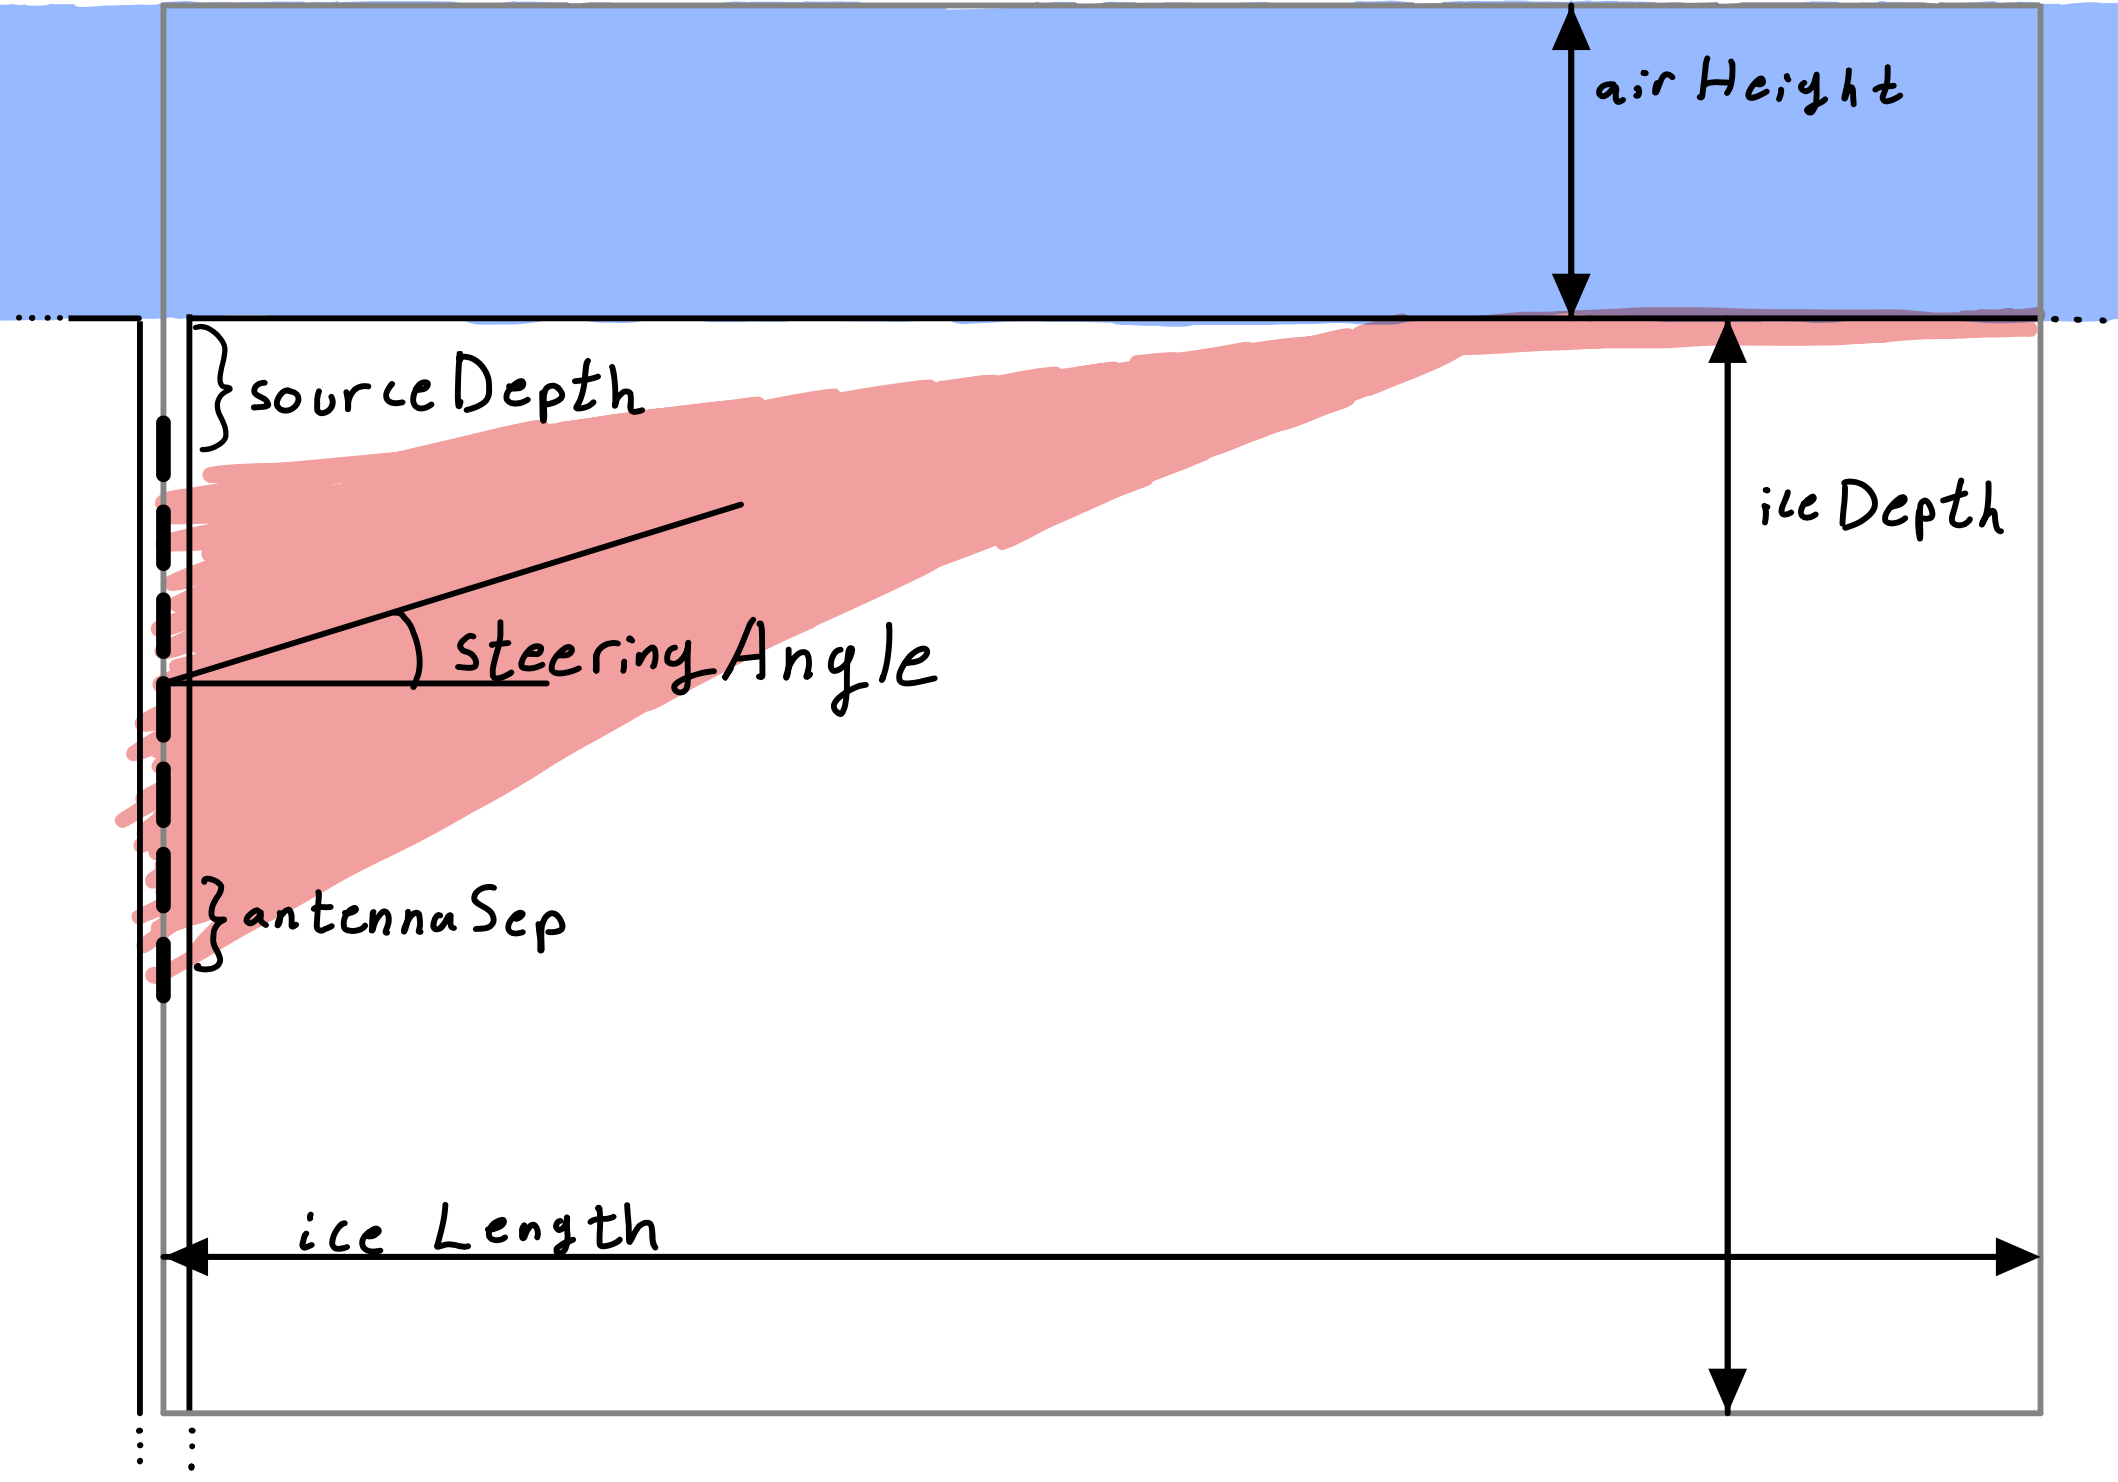

In [1]:
### Importing Packages ###

%matplotlib inline
import matplotlib.pyplot as plt
import math
import paraPropPython as ppp
import numpy as np
from numpy import asarray
from numpy import save
from numpy import unravel_index
import util as util

In [2]:
##### setting up parameters and conditions of simulation #####

name = "1_18_22_3"      # used for files and plots
plotting = True      # if true, the 2 E-field plots 
                     #  * The phased array
                     #  * The dipole that array is compared with

### first, initialize the dimensions of the simulation ###
airHeight = 15. #height above the surface of the ice (m)
iceDepth = 75. #depth below the surface of the ice (m)
iceLength = 100. #radial length away from the antenna
dx = 0.5 #0.05 # m #grid size in the radial direction (m)
dz = 0.5 #0.05 # m #grid size in the vertical direction (m)

### next, initialize the simulation parameters ###
freq = 0.15     #frequency of phased array signal(GHz)
c = 0.3     #Speed of light (m*GHz)
wl = c/freq     #wavelength of phased array signal (m)
k = 2*np.pi/wl     #wave number of phased array signal(m^-1)
antennaSep = wl     #seperation of dipole elements in phased array in linear case
numAntenna =  2 #8      #number of dipole elements in phased array
detector_range_low = 2. #20.     #range of the low range surface detector (m)
detector_range_high = 10. #100.     #range of the long range surface detector (m)
measure_depth = 3     # depth of the typical reflection off in-ice cascade (m)
Rmax = int(iceLength)     # max range for the area region Omega (m)

### next, initialize the phased array optimization parameter space ###
depth_array = np.arange(12,14,1) #np.arange(0,20,1) #possible values for the depth of the top dipole 
phase_array = np.arange(12,14,1) #np.arange(10,40,1) #possible values for the steering angle of the phased array 
a_array = [100000] #possible values a-parameter for the dipole spacing

### next, initialize the threshold cutoff values for set area region Omega ###
threshold_dBds = [6,5,4,3,2,1,0,-1,-2,-3,-4,-5]
threshold_abss = [-60,-62,-64,-65,-66,-67,-68,-69,-70,-71,-72,-74]



### here are some calculated quantities based on these parameters ###
mpp = dz #meters per pixel, used for calculations
column_size = int(iceLength/mpp) #number of pixels in the length of grid space
row_depth = int(((measure_depth + airHeight)/mpp))  # measure depth in pixels
pixel_max = int(Rmax/mpp) # max range for the area region Omega (pixel)

In [3]:
### next, initialize the arrays that store the E-Field values ###

rows = len(phase_array)
columns = len(depth_array)
depths = len(a_array)

arrayESlices = []
arrayNormESlices = []
dipoleESlices = []
dipoleNormESlices = []

for _ in range(rows):
    row = []
    for _ in range(columns):
        column = []
        for _ in range(depths):
            depth = []
            for _ in range(column_size):
                depth.append(0)
            column.append(depth)
        row.append(column)
    arrayNormESlices.append(row)

for _ in range(rows):
    row = []
    for _ in range(columns):
        column = []
        for _ in range(depths):
            depth = []
            for _ in range(column_size):
                depth.append(0)
            column.append(depth)
        row.append(column)
    arrayESlices.append(row)    
    
for _ in range(columns):
    column = []
    for _ in range(depths):
        depth = []
        for _ in range(column_size):
            depth.append(0)
        column.append(depth)
    dipoleNormESlices.append(column)
    
for _ in range(columns):
    column = []
    for _ in range(depths):
        depth = []
        for _ in range(column_size):
            depth.append(0)
        column.append(depth)
    dipoleESlices.append(column)

# Run the Simulation

a =100000
depth =12.0
phi =12


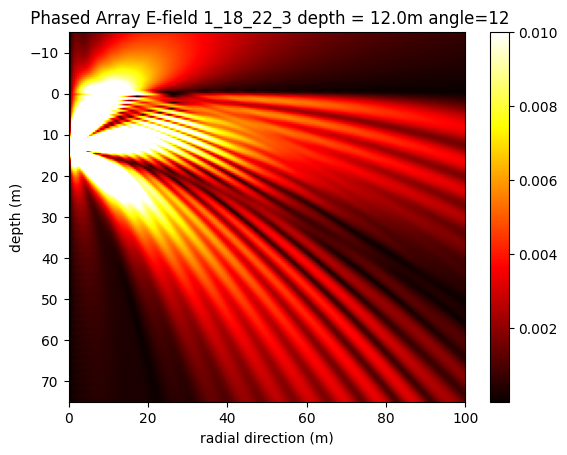

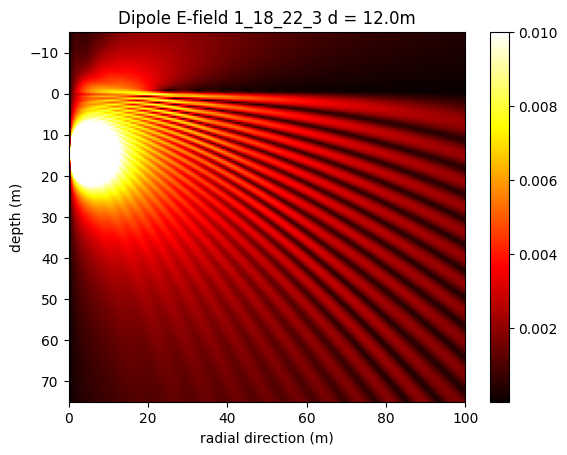

phi =13


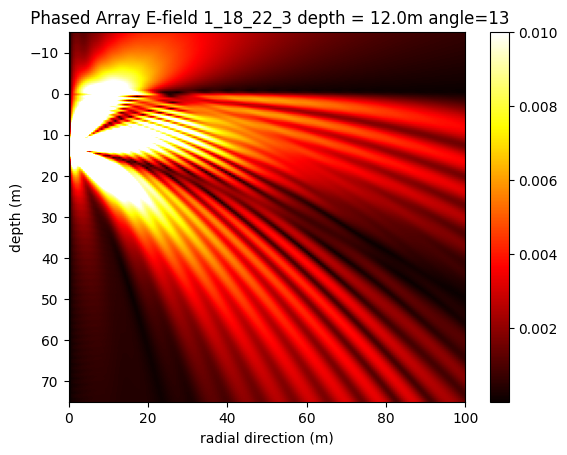

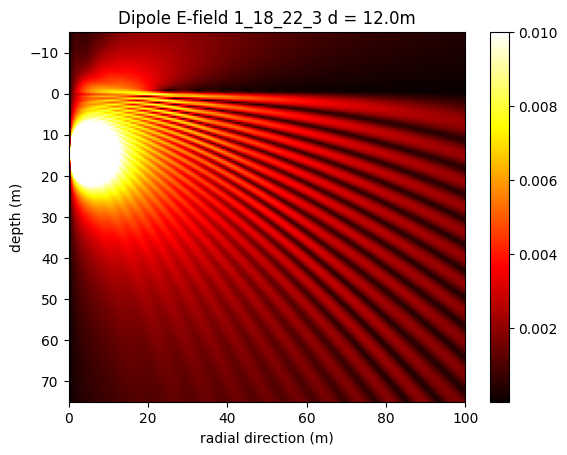

depth =13.0
phi =12


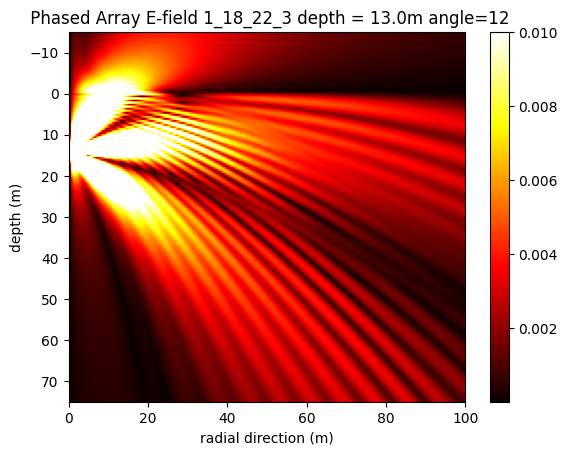

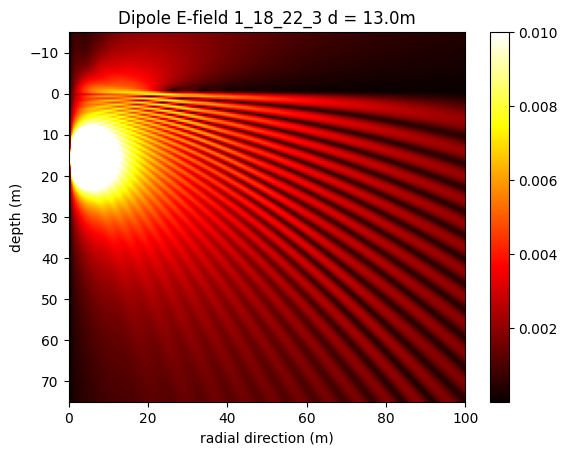

phi =13


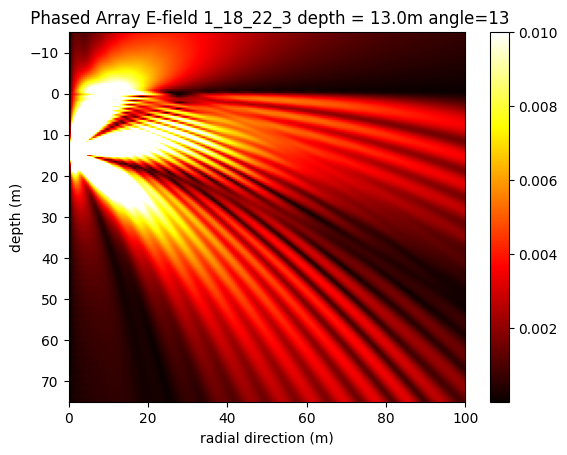

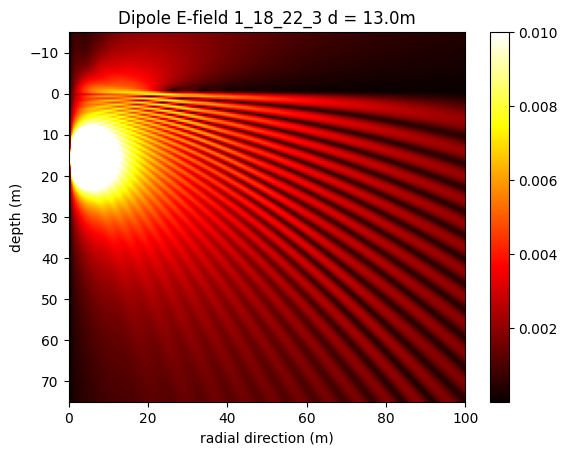

In [4]:
for a_i in range(len(a_array)):
    a_i = int(a_i)
    a = a_array[a_i]
    print("a =" + str(a))
    for d in range(len(depth_array)):
        d = int(d)
        depth_64 = depth_array[d]
        depth = float(depth_64)
        print("depth =" + str(depth))
        
        #### Initialize the dipole simulaiton ####
        dipoleDepth_64 = depth + antennaSep*(a/2)*(1-math.exp(-numAntenna/a)) 
        dipoleDepth = float(dipoleDepth_64)
        dipole_sim = ppp.paraProp(iceLength, iceDepth, dx, dz, airHeight, refDepth=dipoleDepth)
        z_d = dipole_sim.get_z()
        
        ### Set dipole simulaiton index of refraction ###        
        def southpole(z_d):
            A=1.78
            B=-0.43
            C=-0.0132
            return A+B*np.exp(C*z_d)
        dipole_sim.set_n(nFunc=southpole)

        ### Set dipole source ###           
        dipole_sim.set_dipole_source_profile(freq, dipoleDepth)
        dipole_sim.set_cw_source_signal(freq)
        
        ### Run the dipole simulation ###         
        dipole_sim.do_solver()
        
        ### Obtain dipole fields ###         
        dipole_eField = np.transpose(abs(dipole_sim.get_field()))
        dipoleFieldSlice = abs(dipole_sim.get_field(x0=0.1))
        dipoleNormalize = (np.sum(dipoleFieldSlice))
        normDipoleEField = dipole_eField/dipoleNormalize
        
                
        for p in range(len(phase_array)): 
            p = int(p)
            phi = np.deg2rad(phase_array[p])
            print("phi =" + str(phase_array[p]))
            
            #### Initialize the phased array simulaiton ####            
            sim = ppp.paraProp(iceLength, iceDepth, dx, dz, airHeight, refDepth=depth)
            z = sim.get_z()
            x = sim.get_x()
            
            ### Set phased array simulaiton index of refraction ###             
            def southpole(z):
                A=1.78
                B=-0.43
                C=-0.0132
                return A+B*np.exp(C*z)
            sim.set_n(nFunc=southpole)
            
            ### Set phased array source ### 
            sourceDepths = []
            for i in range(numAntenna):
                sourceDepths.append(round((depth + antennaSep*a*(1-math.exp(-i/a)))/dz))     # Exponential Spacing
                #sourceDepths.append(round(float((depth + antennaSep*i)/dz)))     # Plain linear spacing also available
            sourceArray = []
            for i in range(int(iceDepth/dz)):
                sourceArray.append(0)
            for l in range(len(sourceDepths)):
                sourceArray[int(sourceDepths[l])] = np.exp((-1j)*k*antennaSep*l*phi)
            sim.set_user_source_profile('vector', z0=0, sVec=sourceArray, sFunc=None)
            sim.set_cw_source_signal(freq)
            
            ### Run the phased array simulation ###  
            sim.do_solver()     
            
            ### Obtain phased array fields ### 
            eField = np.transpose(abs(sim.get_field()))
            eFieldSlice = abs(sim.get_field(x0=0.1))
            eNormalize = (np.sum(eFieldSlice))
            normEField = eField/eNormalize 
                

            ### Plot the fields
            if plotting == True:
                ## phased array E-field ##
                fig, ax = plt.subplots()
                ax.set_aspect('auto')
                plt.imshow(eField, aspect='auto', cmap='hot',  vmin=1e-5, vmax=1e-2, extent=(x[0], x[-1], z[-1], z[0]))
                ax.set_xlabel("radial direction (m)")
                ax.set_ylabel("depth (m)")
                plt.axis('on')
                plot_title = " Phased Array E-field "+name+" depth = "+str(depth)+"m angle="+str(phase_array[p])
                plt.title(plot_title)
                plt.colorbar()
                plt.show()
                #fig.savefig(plot_title)
               
                ## dipole E-field ##
                fig, ax = plt.subplots()
                ax.set_aspect('auto')
                plt.imshow(dipole_eField, aspect='auto', cmap='hot',  vmin=1e-5, vmax=1e-2, extent=(x[0], x[-1], z[-1], z[0]))
                ax.set_xlabel("radial direction (m)")
                ax.set_ylabel("depth (m)")
                plt.axis('on')
                plot_title = "Dipole E-field "+name+" d = "+str(depth)+"m"
                plt.title(plot_title)
                plt.colorbar()
                plt.show()
                #fig.savefig(plot_title)

            ### save E-fields to array for area calculations ###
            for r_out_dBd in range(column_size):
                arrayESlices[p][d][a_i][r_out_dBd] = eField[row_depth,r_out_dBd]
                dipoleESlices[d][a_i][r_out_dBd] = dipole_eField[row_depth,r_out_dBd]
                arrayNormESlices[p][d][a_i][r_out_dBd] = normEField[row_depth,r_out_dBd]
                dipoleNormESlices[d][a_i][r_out_dBd] = normDipoleEField[row_depth,r_out_dBd]

In [5]:
#### save E-fields to NPY file to use later if needed ####

NPYData = asarray([[arrayESlices,dipoleESlices,arrayNormESlices,dipoleNormESlices]],dtype=object)
save('NPYFiles/EFields'+str(name)+'meas'+str(measure_depth)+'.npy', NPYData)

# Weighted Area Calculations

We'll do these one at a time (Actual Area dBd, Actual Area Abs, Punished Low dBd, ...) in case we only want to gather data from just one calculation. 

In [6]:
### initialize the arrays that store the area integral values ###

actual_area_matrix_dBd = []
punished_low_area_matrix_dBd = []
punished_high_area_matrix_dBd = []
averaged_punished_area_matrix_dBd = []
actual_area_matrix_abs = []
punished_low_area_matrix_abs = []
punished_high_area_matrix_abs = []
averaged_punished_area_matrix_abs = []
for _ in range(rows):
    row = []
    for _ in range(columns):
        column = []
        for _ in range(depths):
            column.append(0)
        row.append(column)
    actual_area_matrix_abs.append(row)
    punished_low_area_matrix_abs.append(row)
    punished_high_area_matrix_abs.append(row)
    averaged_punished_area_matrix_abs.append(row)
    actual_area_matrix_dBd.append(row)
    punished_low_area_matrix_dBd.append(row)
    punished_high_area_matrix_dBd.append(row)
    averaged_punished_area_matrix_dBd.append(row)


In [7]:
### initialize the optimized data files ###
file_actual_area_abs = open('OptimizedData/ActualArea/ActualAreaAbs' + name + '.txt', 'w') #write to file
file_actual_area_dBd = open('OptimizedData/ActualArea/ActualAreadBd' + name + '.txt', 'w') #write to file
file_punished_low_area_abs = open('OptimizedData/PunishedLow/PunishedLowAreaAbs' + name + '.txt', 'w') #write to file
file_punished_low_area_dBd = open('OptimizedData/PunishedLow/PunishedLowAreadBd' + name + '.txt', 'w') #write to file
file_punished_high_area_abs = open('OptimizedData/PunishedHigh/PunishedHighAreaAbs' + name + '.txt', 'w') #write to file
file_punished_high_area_dBd = open('OptimizedData/PunishedHigh/PunishedHighAreadBd' + name + '.txt', 'w') #write to file
file_averaged_punished_area_abs = open('OptimizedData/AveragedPunished/AveragedPunishedAreaAbs' + name + '.txt', 'w') #write to file
file_averaged_punished_area_dBd = open('OptimizedData/AveragedPunished/AveragedPunishedAreadBd' + name + '.txt', 'w') #write to file

### Header to optimized data files ###
file_actual_area_abs.write("AbsThreshold" + "  " + "BestDepthAbs" + "  " + "BestAngleAbs" + "  " + "AreaAbs" +'\n')
file_actual_area_dBd.write("dBdThreshold" + "  " + "BestDepthdBd" + "  " + "BestAngledBd" + "  " + "AreadBd" +'\n')
file_punished_low_area_abs.write("AbsThreshold" + "  " + "BestDepthAbs" + "  " + "BestAngleAbs" + "  " + "AreaAbs" +'\n')
file_punished_low_area_dBd.write("dBdThreshold" + "  " + "BestDepthdBd" + "  " + "BestAngledBd" + "  " + "AreadBd" +'\n')
file_punished_high_area_abs.write("AbsThreshold" + "  " + "BestDepthAbs" + "  " + "BestAngleAbs" + "  " + "AreaAbs" +'\n')
file_punished_high_area_dBd.write("dBdThreshold" + "  " + "BestDepthdBd" + "  " + "BestAngledBd" + "  " + "AreadBd" +'\n')
file_averaged_punished_area_abs.write("AbsThreshold" + "  " + "BestDepthAbs" + "  " + "BestAngleAbs" + "  " + "AreaAbs" +'\n')
file_averaged_punished_area_dBd.write("dBdThreshold" + "  " + "BestDepthdBd" + "  " + "BestAngledBd" + "  " + "AreadBd" +'\n')

50

## Actual Area dBd

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 6 are 
 depth:[12, 12]
 phase:[12, 13]
 a:[100000, 100000]
 with an area of:1452.9866022852793


/var/folders/7c/ctd744mx4bjchcjkw9s71m1r0000gn/T/ipykernel_50625/386075300.py:22: RuntimeWarning: invalid value encountered in double_scalars
  if (arrayNormESlices[p][d][a_i][r_out_dBd]/dipoleNormESlices[d][a_i][r_out_dBd])**2 <= 0:
/var/folders/7c/ctd744mx4bjchcjkw9s71m1r0000gn/T/ipykernel_50625/386075300.py:25: RuntimeWarning: invalid value encountered in double_scalars
  if threshold_dBd < 10*math.log10((arrayNormESlices[p][d][a_i][r_out_dBd]/dipoleNormESlices[d][a_i][r_out_dBd])**2):


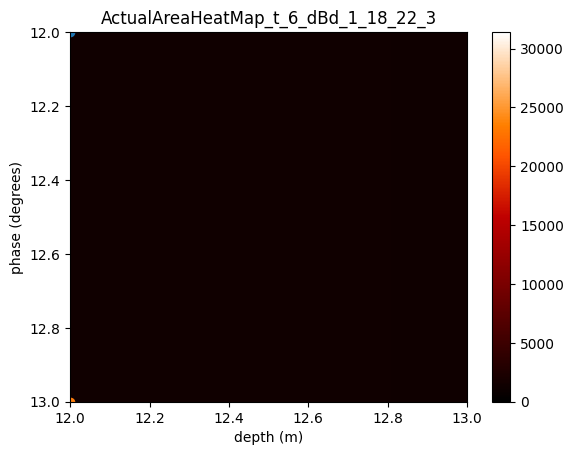

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 5 are 
 depth:[13]
 phase:[13]
 a:[100000]
 with an area of:1812.6989611213107


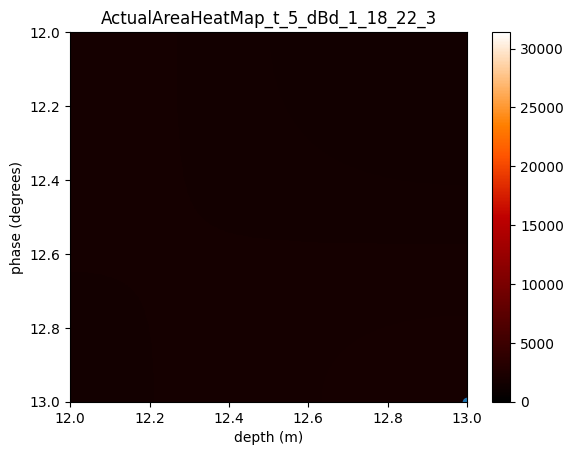

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 4 are 
 depth:[12, 12]
 phase:[12, 13]
 a:[100000, 100000]
 with an area of:1899.09275909503


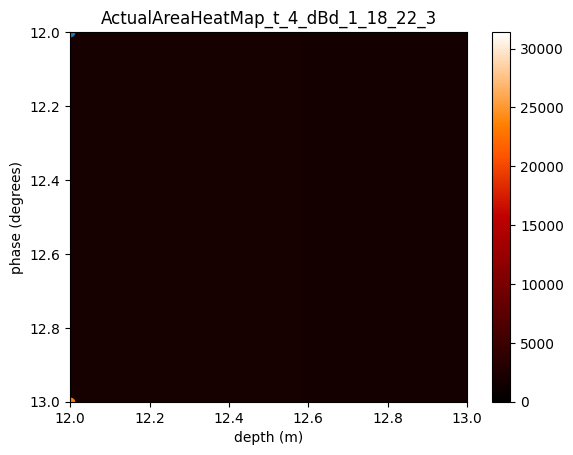

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 3 are 
 depth:[13]
 phase:[13]
 a:[100000]
 with an area of:2445.7298808196538


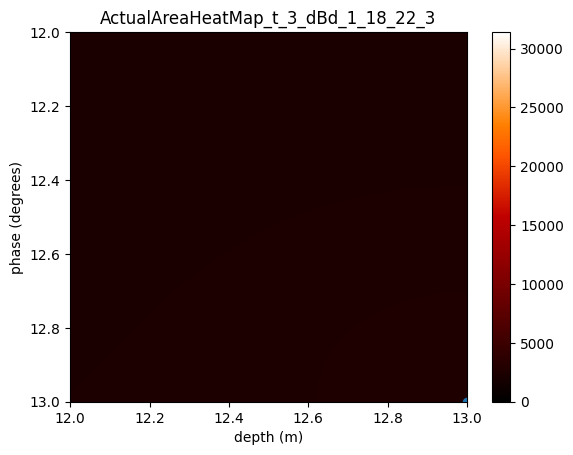

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 2 are 
 depth:[13]
 phase:[13]
 a:[100000]
 with an area of:2924.8227604920976


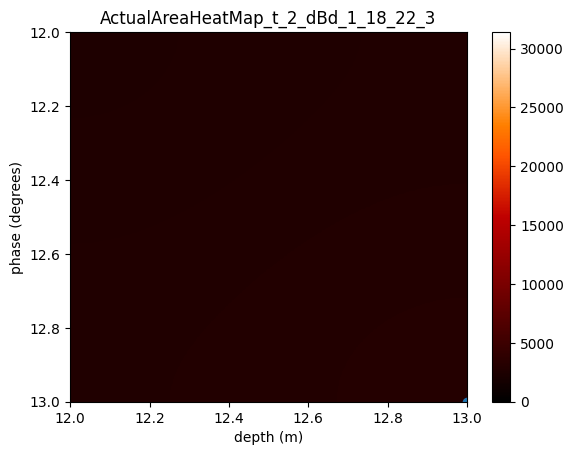

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 1 are 
 depth:[13]
 phase:[13]
 a:[100000]
 with an area of:3747.920035732623


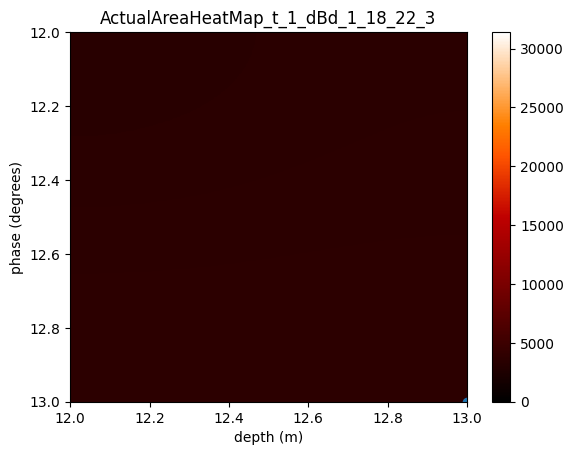

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 0 are 
 depth:[12]
 phase:[13]
 a:[100000]
 with an area of:4710.8181840578945


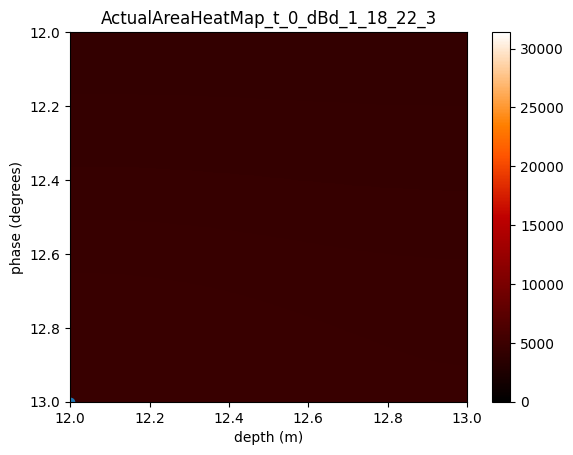

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of -1 are 
 depth:[12]
 phase:[13]
 a:[100000]
 with an area of:6701.017130107029


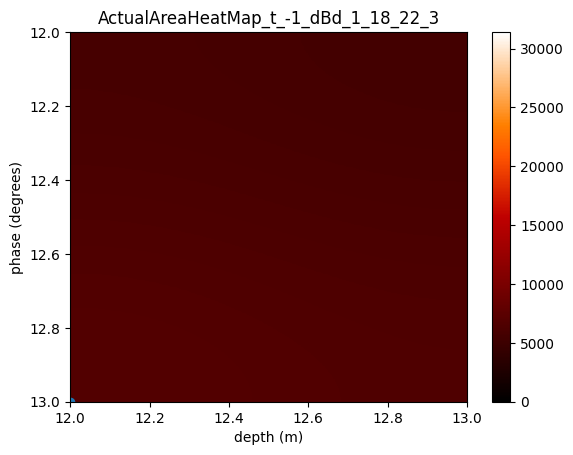

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of -2 are 
 depth:[12]
 phase:[13]
 a:[100000]
 with an area of:9919.578803709772


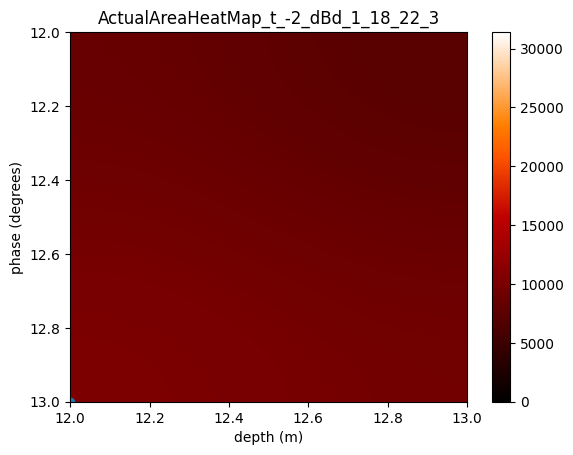

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of -3 are 
 depth:[12]
 phase:[13]
 a:[100000]
 with an area of:20165.883243392884


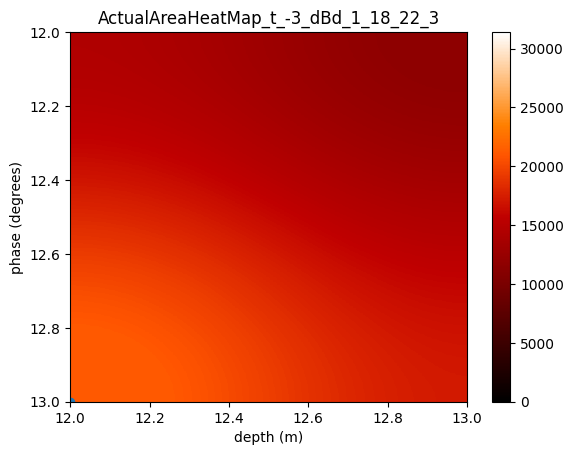

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of -4 are 
 depth:[12]
 phase:[13]
 a:[100000]
 with an area of:25966.834078246437


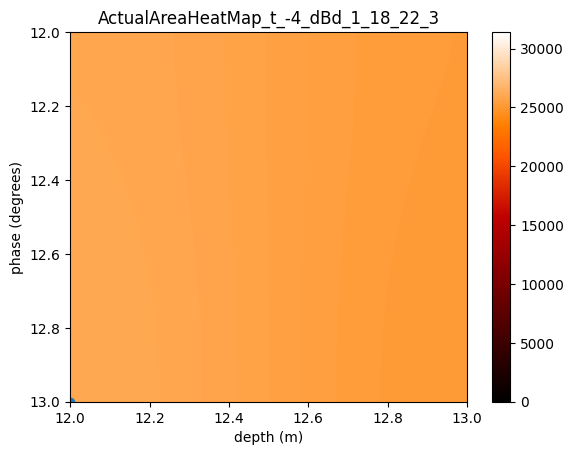

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of -5 are 
 depth:[12]
 phase:[13]
 a:[100000]
 with an area of:26618.714553866317


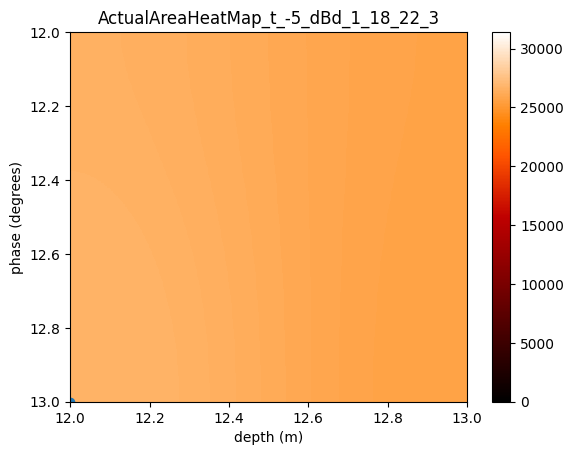

In [8]:
maxActualdBdarea = 0

for i in range(len(threshold_dBds)):
    threshold_dBd = threshold_dBds[i]
    for a_i in range(len(a_array)):
        a = a_array[a_i]
        print("a = " + str(a))
        for d in range(len(depth_array)):
            depth_64 = depth_array[d]
            depth = float(depth_64)
            print("depth = " + str(depth))
            
            for p in range(len(phase_array)): 
                print("phi = " + str(phase_array[p]))
                phi = np.deg2rad(phase_array[p])

                
                #### calculate the area integral ####
                actual_area_integral_dBd = 0
                for r_out_dBd in range(column_size):
                    if r_out_dBd < pixel_max:
                        if (arrayNormESlices[p][d][a_i][r_out_dBd]/dipoleNormESlices[d][a_i][r_out_dBd])**2 <= 0:
                            arrayNormESlices[p][d][a_i][r_out_dBd] = 0.0000000000001
                            dipoleNormESlices[d][a_i][r_out_dBd] = 1
                        if threshold_dBd < 10*math.log10((arrayNormESlices[p][d][a_i][r_out_dBd]/dipoleNormESlices[d][a_i][r_out_dBd])**2):
                            actual_area_integral_dBd += r_out_dBd*mpp*mpp

                actual_area_matrix_dBd[p][d][a_i] = 2*np.pi*actual_area_integral_dBd

                
    ### Finding the maximum area and the set(s) of parameters ###
    actual_area_dBd_max = 0 
    maxActualAREAvaluesDBD = []
    actual_area_phase_dBd_max = 0
    actualAreaMaxPHASEvaluesDBD = []
    actual_area_depth_dBd_max = 0
    actualAreaMaxDEPTHvaluesDBD = []
    actual_area_a_dBd_max = 0
    actualAreaMaxAvaluesDBD = []
    for p in range(len(phase_array)):
        for d in range(len(depth_array)):
            for a in range(len(a_array)):
                if actual_area_dBd_max <= actual_area_matrix_dBd[p][d][a]:
                    maxActualAREAvaluesDBD.append(actual_area_matrix_dBd[p][d][a])
                    actual_area_dBd_max = actual_area_matrix_dBd[p][d][a]
                    actual_area_phase_dBd_max = phase_array[p]
                    actualAreaMaxPHASEvaluesDBD.append(actual_area_phase_dBd_max)
                    actual_area_depth_dBd_max = depth_array[d]
                    actualAreaMaxDEPTHvaluesDBD.append(actual_area_depth_dBd_max)
                    actual_area_a_dBd_max = a_array[a]
                    actualAreaMaxAvaluesDBD.append(actual_area_a_dBd_max)
     
    actual_area_indices_dBd = []
    actualAreaMaximizedAvaluesDBD = []
    actualAreaMaximizedDEPTHvaluesDBD = []
    actualAreaMaximizedPHASEvaluesDBD = []
    actualAreaMaximizedAREAvaluesDBD = []

    biggest_actual_area_dBd = max(maxActualAREAvaluesDBD)

    for y in range(len(maxActualAREAvaluesDBD)):
        if maxActualAREAvaluesDBD[y] == biggest_actual_area_dBd:
            actual_area_indices_dBd.append(y)
    
    for z in actual_area_indices_dBd:
        actualAreaMaximizedAvaluesDBD.append(actualAreaMaxAvaluesDBD[z])
        actualAreaMaximizedDEPTHvaluesDBD.append(actualAreaMaxDEPTHvaluesDBD[z])
        actualAreaMaximizedPHASEvaluesDBD.append(actualAreaMaxPHASEvaluesDBD[z])
        actualAreaMaximizedAREAvaluesDBD.append(maxActualAREAvaluesDBD[z])

        
    ### print the best set of parameters from a threshold to the optimized data file ###
    print('The best parameters from a dBd threshold of ' + str(threshold_dBd) + ' are \n depth:' + str(actualAreaMaximizedDEPTHvaluesDBD) + '\n phase:' + str(actualAreaMaximizedPHASEvaluesDBD) + 
          '\n a:' + str(actualAreaMaximizedAvaluesDBD) + '\n with an area of:' + str(biggest_actual_area_dBd))
    if biggest_actual_area_dBd > maxActualdBdarea:
        maxActualdBdarea = biggest_actual_area_dBd

        
    ## plot the heat map ##
    fig, ax = plt.subplots()
    ax.set_aspect('auto')
    actual_area_trans_dBd = np.transpose(actual_area_matrix_dBd)
    actual_area_heat_map_dBd = np.transpose(actual_area_trans_dBd[0])
    # add dots for best design #
    for _ in range(len(actual_area_indices_dBd)):
        plt.scatter(actualAreaMaximizedDEPTHvaluesDBD[_],actualAreaMaximizedPHASEvaluesDBD[_])
    plt.imshow(actual_area_heat_map_dBd, extent=[depth_array[0],depth_array[-1],phase_array[-1],phase_array[0]], aspect = "auto", vmin=0, vmax=31400, interpolation='spline36', cmap='gist_heat', alpha=1)               
    ax.set_xlabel("depth (m)")
    ax.set_ylabel("phase (degrees)")
    plt.axis('on')
    actual_area_plot_title_dBd = "ActualAreaHeatMap_t_"+str(threshold_dBd)+"_dBd_"+name
    plt.title(actual_area_plot_title_dBd)
    plt.colorbar()
    plt.show()
    fig.savefig('ThresholdPlots/ActualArea/'+actual_area_plot_title_dBd+'.png')                  

    
    ## write the best set of parameters from a threshold to the optimized data file ##
    for _ in range(len(actual_area_indices_dBd)):
        file_actual_area_dBd.write( "     " + str(threshold_dBd) + "             " + str(actualAreaMaximizedDEPTHvaluesDBD[_]) + "          " + str(actualAreaMaximizedPHASEvaluesDBD[_]) + "          " + str(actualAreaMaximizedAREAvaluesDBD[_])  +'\n')
    
file_actual_area_dBd.close()

In [9]:
### Creating a GIFs of all the heat maps from the various thresholds ###

from PIL import Image
import glob
 
# Create the frames
frames = []
imgs = glob.glob('ThresholdPlots/ActualArea/*dBd_'+ name +'.png')
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 
# Save into a GIF file that loops forever
frames[0].save('ThresholdPlots/GIFs/ActualAreaAnimationdBd_'+name+'.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

## Actual Area Abs

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a abs threshold of -60 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


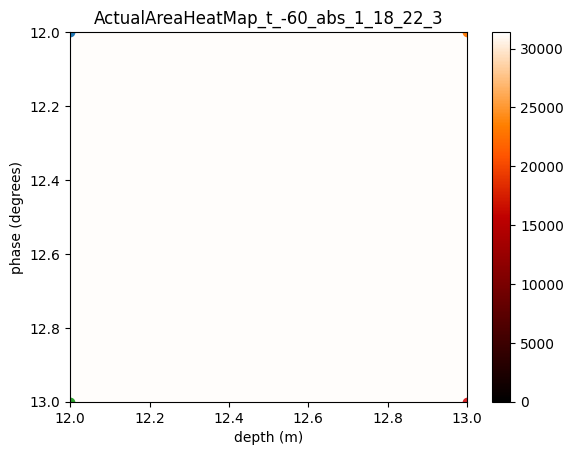

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a abs threshold of -62 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


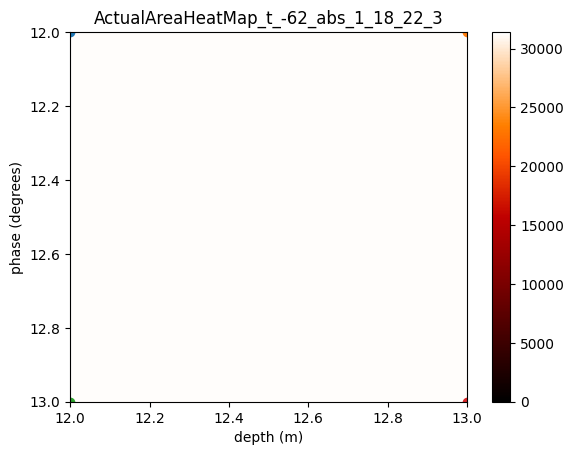

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a abs threshold of -64 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


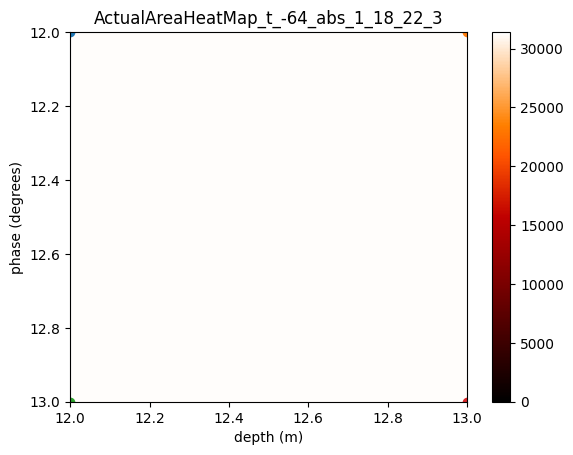

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a abs threshold of -65 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


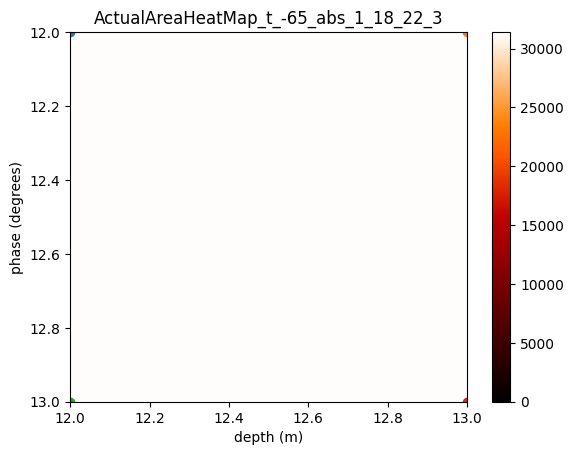

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a abs threshold of -66 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


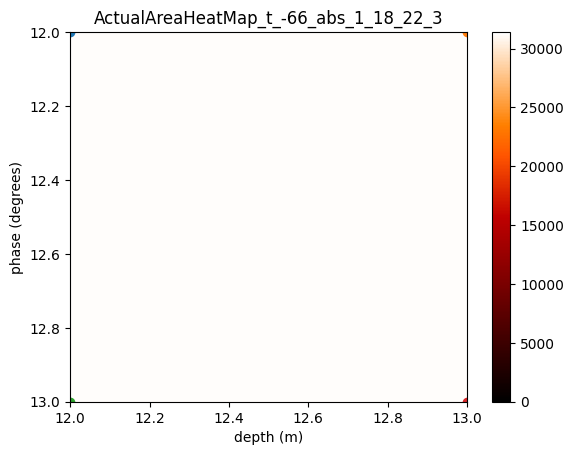

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a abs threshold of -67 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


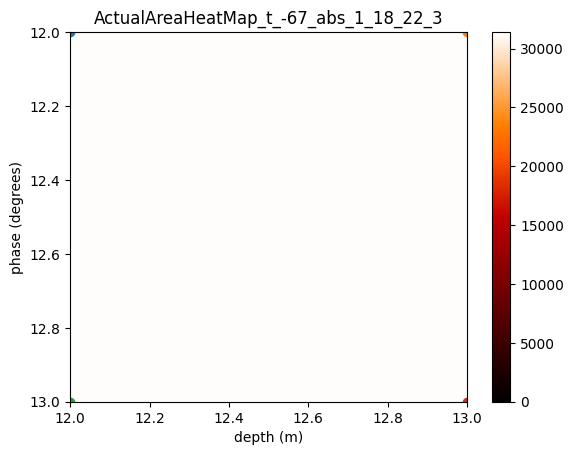

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a abs threshold of -68 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


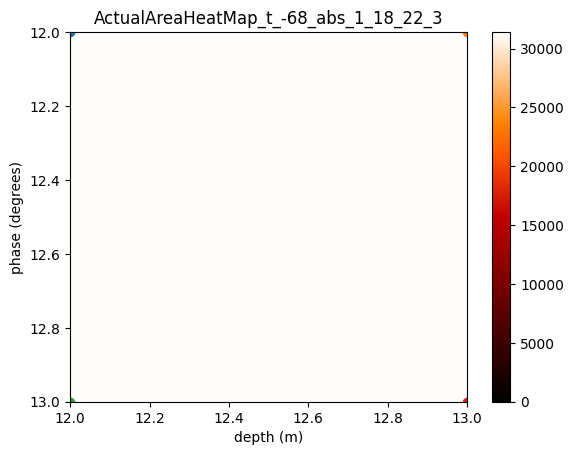

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a abs threshold of -69 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


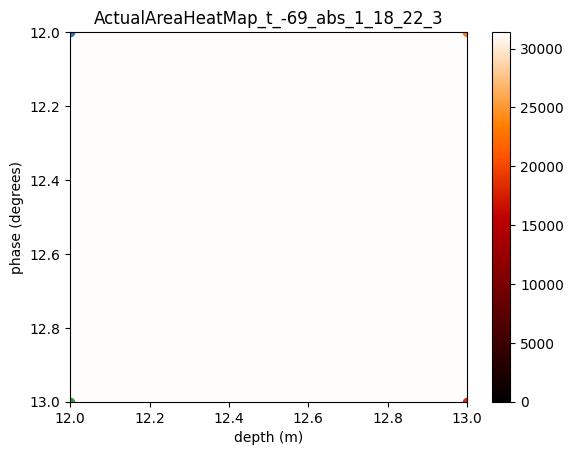

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a abs threshold of -70 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


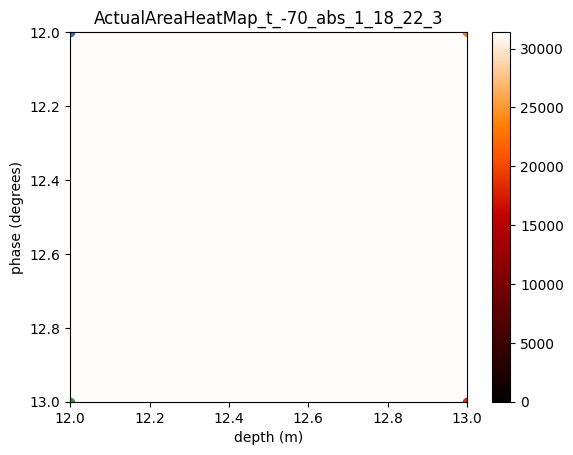

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a abs threshold of -71 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


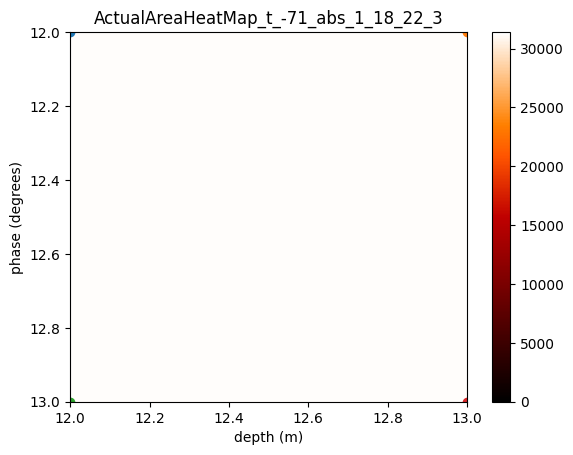

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a abs threshold of -72 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


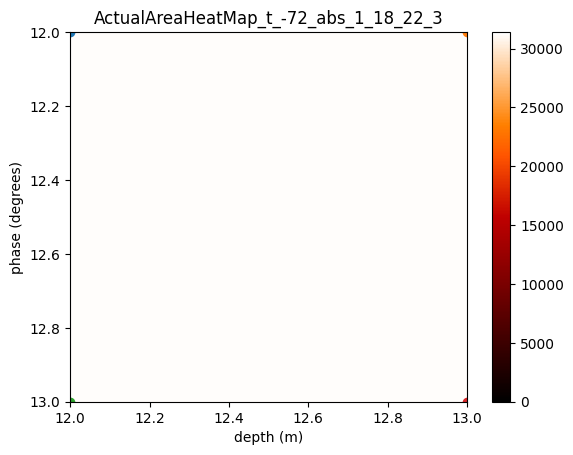

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a abs threshold of -74 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


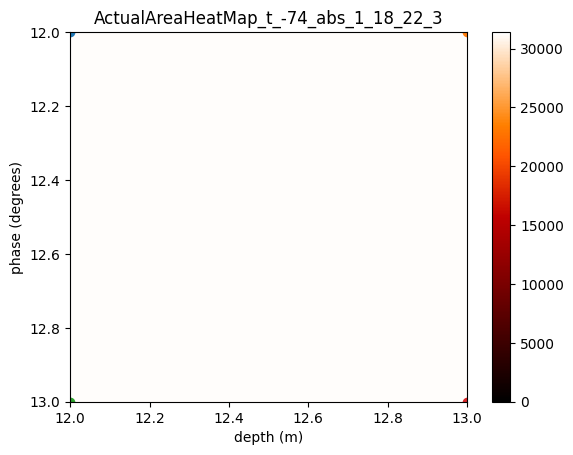

In [10]:
maxActualAbsarea = 0

for i in range(len(threshold_abss)):
    threshold_abs = threshold_abss[i]
    for a_i in range(len(a_array)):
        a = a_array[a_i]
        print("a = " + str(a))
        for d in range(len(depth_array)):
            depth_64 = depth_array[d]
            depth = float(depth_64)
            print("depth = " + str(depth))
            for p in range(len(phase_array)): 
                print("phi = " + str(phase_array[p]))
                phi = np.deg2rad(phase_array[p])

                #### calculate the area integral ####
                actual_area_integral_abs = 0
                for r_out_abs in range(column_size):
                    if r_out_abs < pixel_max:
                        if arrayESlices[p][d][a_i][r_out_abs] == 0:
                            arrayESlices[p][d][a_i][r_out_abs] = 0.0000000001
                        if threshold_abs < 10*math.log10((arrayESlices[p][d][a_i][r_out_abs])**2):
                            actual_area_integral_abs += r_out_abs*mpp*mpp

                actual_area_matrix_abs[p][d][a_i] = 2*np.pi*actual_area_integral_abs

                
    ### Finding the maximum area and the set(s) of parameters ###
    actual_area_abs_max = 0 
    maxActualAREAvaluesABS = []
    actual_area_phase_abs_max = 0
    actualAreaMaxPHASEvaluesABS = []
    actual_area_depth_abs_max = 0
    actualAreaMaxDEPTHvaluesABS = []
    actual_area_a_abs_max = 0
    actualAreaMaxAvaluesABS = []
    for p in range(len(phase_array)):
        for d in range(len(depth_array)):
            for a in range(len(a_array)):
                if actual_area_abs_max <= actual_area_matrix_abs[p][d][a]:
                    maxActualAREAvaluesABS.append(actual_area_matrix_abs[p][d][a])
                    actual_area_abs_max = actual_area_matrix_abs[p][d][a]
                    actual_area_phase_abs_max = phase_array[p]
                    actualAreaMaxPHASEvaluesABS.append(actual_area_phase_abs_max)
                    actual_area_depth_abs_max = depth_array[d]
                    actualAreaMaxDEPTHvaluesABS.append(actual_area_depth_abs_max)
                    actual_area_a_abs_max = a_array[a]
                    actualAreaMaxAvaluesABS.append(actual_area_a_abs_max)
     
    actual_area_indices_abs = []
    actualAreaMaximizedAvaluesABS = []
    actualAreaMaximizedDEPTHvaluesABS = []
    actualAreaMaximizedPHASEvaluesABS = []
    actualAreaMaximizedAREAvaluesABS = []
    
    biggest_actual_area_abs = max(maxActualAREAvaluesABS)

    for y in range(len(maxActualAREAvaluesABS)):
        if maxActualAREAvaluesABS[y] == biggest_actual_area_abs:
            actual_area_indices_abs.append(y)
    
    for z in actual_area_indices_abs:
        actualAreaMaximizedAvaluesABS.append(actualAreaMaxAvaluesABS[z])
        actualAreaMaximizedDEPTHvaluesABS.append(actualAreaMaxDEPTHvaluesABS[z])
        actualAreaMaximizedPHASEvaluesABS.append(actualAreaMaxPHASEvaluesABS[z])
        actualAreaMaximizedAREAvaluesABS.append(maxActualAREAvaluesABS[z])

        
    ## print the best set of parameters from a threshold to the optimized data file ##    
    print('The best parameters from a abs threshold of ' + str(threshold_abs) + ' are \n depth:' + str(actualAreaMaximizedDEPTHvaluesABS) + '\n phase:' + str(actualAreaMaximizedPHASEvaluesABS) + 
          '\n a:' + str(actualAreaMaximizedAvaluesABS) + '\n with an area of:' + str(actualAreaMaximizedAREAvaluesABS))

    if biggest_actual_area_abs > maxActualAbsarea:
        maxActualAbsarea = biggest_actual_area_abs

        
    ## plot the heat map ##    
    fig, ax = plt.subplots()
    ax.set_aspect('auto')
    actual_area_trans_abs = np.transpose(actual_area_matrix_abs)
    actual_area_heat_map_abs = np.transpose(actual_area_trans_abs[0])
    # add dots for best design #
    for _ in range(len(actual_area_indices_abs)):
        plt.scatter(actualAreaMaximizedDEPTHvaluesABS[_],actualAreaMaximizedPHASEvaluesABS[_])
    plt.imshow(actual_area_heat_map_abs, extent=[depth_array[0],depth_array[-1],phase_array[-1],phase_array[0]], aspect = "auto", vmin=0, vmax=31400, interpolation='spline36', cmap='gist_heat', alpha=1)
    ax.set_xlabel("depth (m)")
    ax.set_ylabel("phase (degrees)")
    plt.axis('on')
    actual_area_plot_title_abs = "ActualAreaHeatMap_t_"+str(threshold_abs)+"_abs_"+name
    plt.title(actual_area_plot_title_abs)
    plt.colorbar()
    plt.show()
    fig.savefig('ThresholdPlots/ActualArea/'+ actual_area_plot_title_abs +'.png') 

    
    ## write the best set of parameters from a threshold to the optimized data file ##
    for _ in range(len(actual_area_indices_abs)):
        file_actual_area_abs.write( "     " + str(threshold_abs) + "             " + str(actualAreaMaximizedDEPTHvaluesABS[_]) + "          " + str(actualAreaMaximizedPHASEvaluesABS[_]) + "          " + str(actualAreaMaximizedAREAvaluesABS[_])  +'\n')
    
file_actual_area_abs.close()

In [11]:
### Creating a GIFs of all the heat maps from the various thresholds ###

from PIL import Image
import glob
 
# Create the frames
frames = []
imgs = glob.glob('ThresholdPlots/ActualArea/*abs_'+ name +'.png')
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 
# Save into a GIF file that loops forever
frames[0].save('ThresholdPlots/GIFs/ActualAreaAnimationAbs_'+name+'.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

## Punished area from low range detector dBd

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 6 are 
 depth:[12, 12]
 phase:[12, 13]
 a:[100000, 100000]
 with an area of:[1452.9866022852793, 1452.9866022852793]


/var/folders/7c/ctd744mx4bjchcjkw9s71m1r0000gn/T/ipykernel_50625/373276602.py:21: RuntimeWarning: invalid value encountered in double_scalars
  if (arrayNormESlices[p][d][a_i][r_out_dBd]/dipoleNormESlices[d][a_i][r_out_dBd])**2 <= 0:
/var/folders/7c/ctd744mx4bjchcjkw9s71m1r0000gn/T/ipykernel_50625/373276602.py:24: RuntimeWarning: invalid value encountered in double_scalars
  if threshold_dBd < 10*math.log10((arrayNormESlices[p][d][a_i][r_out_dBd]/dipoleNormESlices[d][a_i][r_out_dBd])**2):


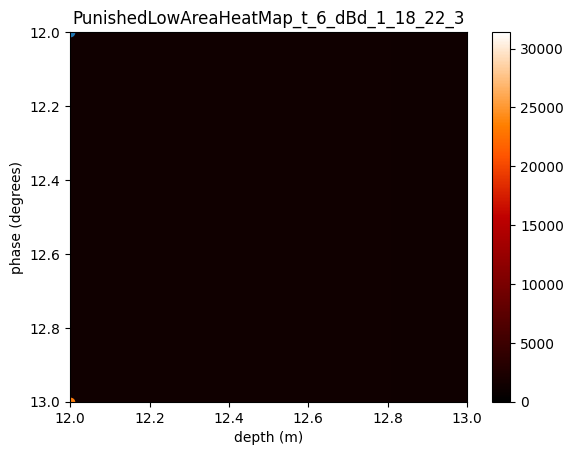

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 5 are 
 depth:[13]
 phase:[13]
 a:[100000]
 with an area of:[1812.6989611213107]


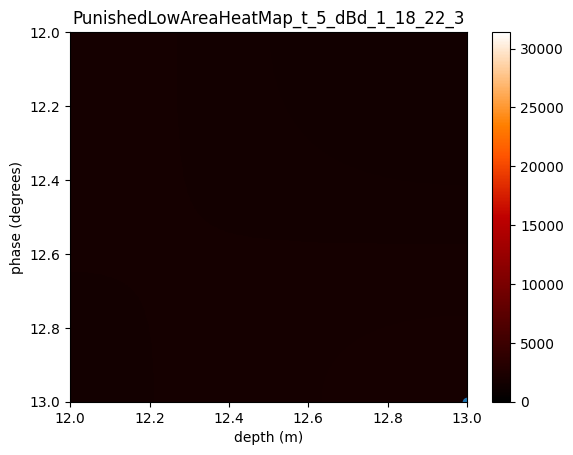

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 4 are 
 depth:[12, 12]
 phase:[12, 13]
 a:[100000, 100000]
 with an area of:[1899.09275909503, 1899.09275909503]


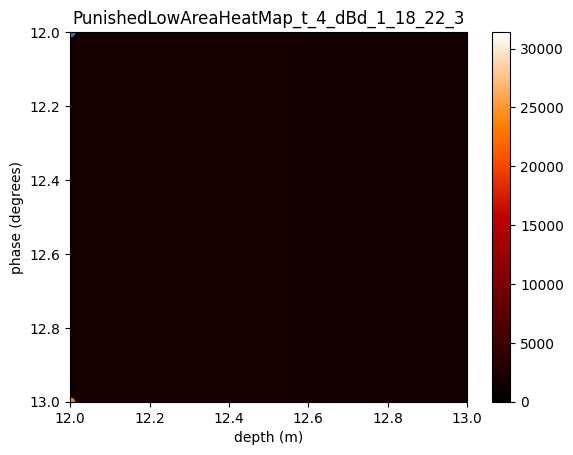

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 3 are 
 depth:[13]
 phase:[13]
 a:[100000]
 with an area of:[2445.7298808196538]


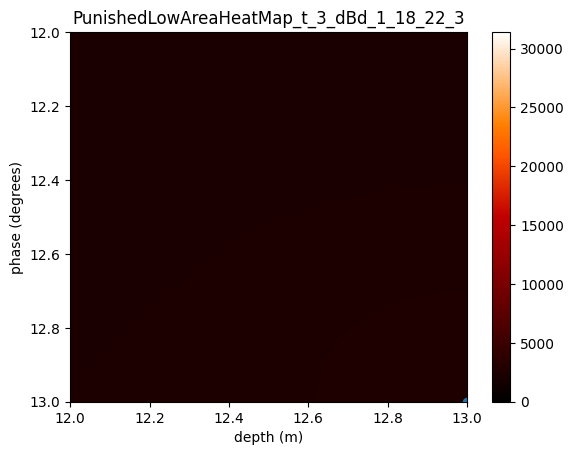

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 2 are 
 depth:[13]
 phase:[13]
 a:[100000]
 with an area of:[2924.8227604920976]


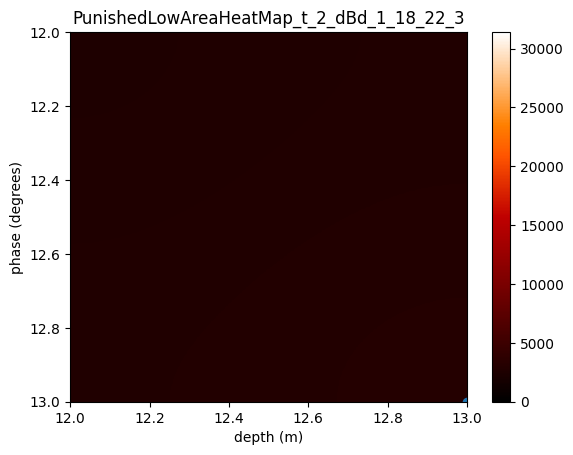

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 1 are 
 depth:[13]
 phase:[13]
 a:[100000]
 with an area of:[3747.920035732623]


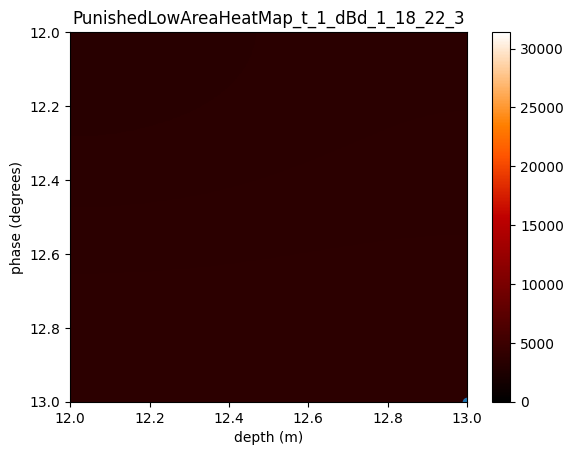

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 0 are 
 depth:[12]
 phase:[13]
 a:[100000]
 with an area of:[4710.8181840578945]


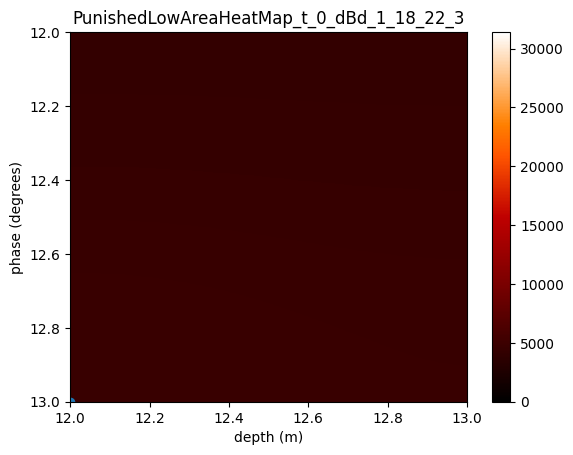

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of -1 are 
 depth:[12]
 phase:[13]
 a:[100000]
 with an area of:[6701.017130107029]


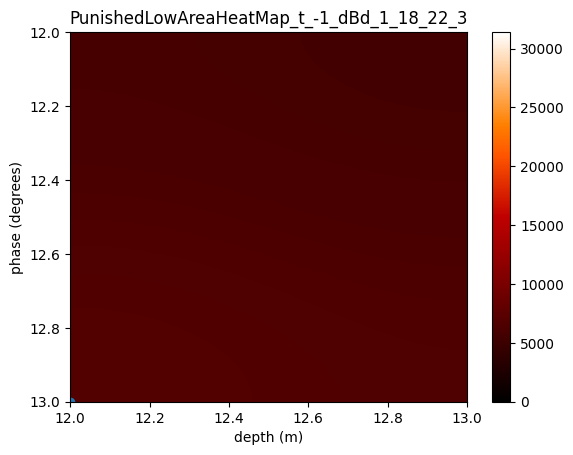

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of -2 are 
 depth:[12]
 phase:[13]
 a:[100000]
 with an area of:[9919.578803709772]


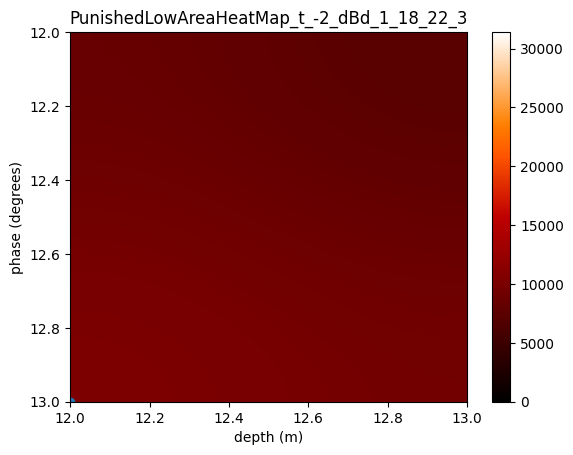

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of -3 are 
 depth:[12]
 phase:[13]
 a:[100000]
 with an area of:[20165.883243392884]


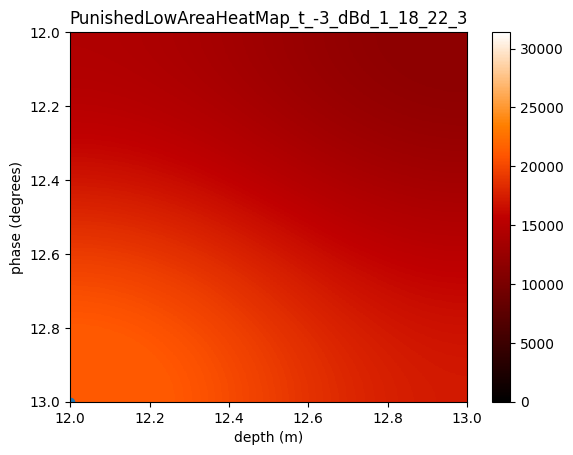

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of -4 are 
 depth:[12]
 phase:[13]
 a:[100000]
 with an area of:[25966.834078246437]


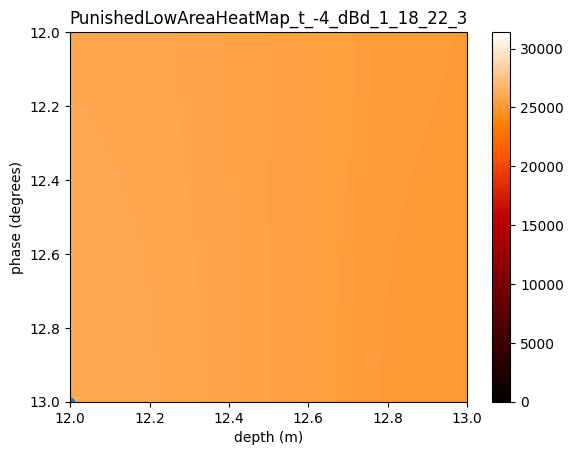

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of -5 are 
 depth:[12]
 phase:[13]
 a:[100000]
 with an area of:[26618.714553866317]


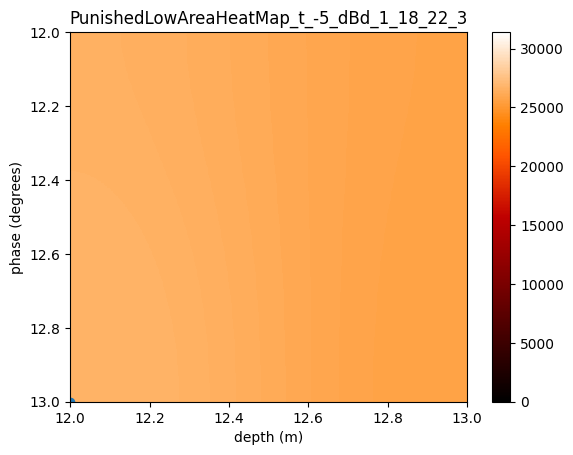

In [12]:
maxPunishedLowdBdarea = 0

for i in range(len(threshold_dBds)):
    threshold_dBd = threshold_dBds[i]
    for a_i in range(len(a_array)):
        a = a_array[a_i]
        print("a = " + str(a))
        for d in range(len(depth_array)):
            depth_64 = depth_array[d]
            depth = float(depth_64)
            print("depth = " + str(depth))
            for p in range(len(phase_array)): 
                print("phi = " + str(phase_array[p]))
                phi = np.deg2rad(phase_array[p])

                
                #### calculate the area integral ####
                punished_low_area_integral_dBd = 0
                for r_out_dBd in range(column_size):
                    if r_out_dBd < pixel_max:
                        if (arrayNormESlices[p][d][a_i][r_out_dBd]/dipoleNormESlices[d][a_i][r_out_dBd])**2 <= 0:
                            arrayNormESlices[p][d][a_i][r_out_dBd] = 0.0000000000001
                            dipoleNormESlices[d][a_i][r_out_dBd] = 1
                        if threshold_dBd < 10*math.log10((arrayNormESlices[p][d][a_i][r_out_dBd]/dipoleNormESlices[d][a_i][r_out_dBd])**2):
                            punished_low_area_integral_dBd += r_out_dBd*mpp*mpp

                punished_low_area_matrix_dBd[p][d][a_i] = 2*np.pi*punished_low_area_integral_dBd

                
    ### Finding the maximum area and the set(s) of parameters ###
    punished_low_area_dBd_max = 0 
    maxPunishedLowAREAvaluesDBD = []
    punished_low_area_phase_dBd_max = 0
    punishedLowAreaMaxPHASEvaluesDBD = []
    punished_low_area_depth_dBd_max = 0
    punishedLowAreaMaxDEPTHvaluesDBD = []
    punished_low_area_a_dBd_max = 0
    punishedLowAreaMaxAvaluesDBD = []
    for p in range(len(phase_array)):
        for d in range(len(depth_array)):
            for a in range(len(a_array)):
                if punished_low_area_dBd_max <= punished_low_area_matrix_dBd[p][d][a]:
                    maxPunishedLowAREAvaluesDBD.append(punished_low_area_matrix_dBd[p][d][a])
                    punished_low_area_dBd_max = punished_low_area_matrix_dBd[p][d][a]
                    punished_low_area_phase_dBd_max = phase_array[p]
                    punishedLowAreaMaxPHASEvaluesDBD.append(punished_low_area_phase_dBd_max)
                    punished_low_area_depth_dBd_max = depth_array[d]
                    punishedLowAreaMaxDEPTHvaluesDBD.append(punished_low_area_depth_dBd_max)
                    punished_low_area_a_dBd_max = a_array[a]
                    punishedLowAreaMaxAvaluesDBD.append(punished_low_area_a_dBd_max)
     
    punished_low_area_indices_dBd = []
    punishedLowAreaMaximizedAvaluesDBD = []
    punishedLowAreaMaximizedDEPTHvaluesDBD = []
    punishedLowAreaMaximizedPHASEvaluesDBD = []
    punishedLowAreaMaximizedAREAvaluesDBD = []
    
    biggest_punished_low_area_dBd = max(maxPunishedLowAREAvaluesDBD)

    for y in range(len(maxPunishedLowAREAvaluesDBD)):
        if maxPunishedLowAREAvaluesDBD[y] == biggest_punished_low_area_dBd:
            punished_low_area_indices_dBd.append(y)
    
    for z in punished_low_area_indices_dBd:
        punishedLowAreaMaximizedAvaluesDBD.append(punishedLowAreaMaxAvaluesDBD[z])
        punishedLowAreaMaximizedDEPTHvaluesDBD.append(punishedLowAreaMaxDEPTHvaluesDBD[z])
        punishedLowAreaMaximizedPHASEvaluesDBD.append(punishedLowAreaMaxPHASEvaluesDBD[z])
        punishedLowAreaMaximizedAREAvaluesDBD.append(maxPunishedLowAREAvaluesDBD[z])

        
    ## print the best set of parameters from a threshold to the optimized data file ##
    print('The best parameters from a dBd threshold of ' + str(threshold_dBd) + ' are \n depth:' + str(punishedLowAreaMaximizedDEPTHvaluesDBD) + '\n phase:' + str(punishedLowAreaMaximizedPHASEvaluesDBD) + 
          '\n a:' + str(punishedLowAreaMaximizedAvaluesDBD) + '\n with an area of:' + str(punishedLowAreaMaximizedAREAvaluesDBD))
    
    if biggest_punished_low_area_dBd > maxPunishedLowdBdarea:
        maxPunishedLowdBdarea = biggest_punished_low_area_dBd

        
    ## plot the heat map ##
    fig, ax = plt.subplots()
    ax.set_aspect('auto')
    punished_low_area_trans_dBd = np.transpose(punished_low_area_matrix_dBd)
    punished_low_area_heat_map_dBd = np.transpose(punished_low_area_trans_dBd[0])
    # add dots for best design #
    for _ in range(len(punished_low_area_indices_dBd)):
        plt.scatter(punishedLowAreaMaximizedDEPTHvaluesDBD[_],punishedLowAreaMaximizedPHASEvaluesDBD[_])
    plt.imshow(punished_low_area_heat_map_dBd, extent=[depth_array[0],depth_array[-1],phase_array[-1],phase_array[0]], aspect = "auto", vmin=0, vmax=31400, interpolation='spline36', cmap='gist_heat', alpha=1)               
    ax.set_xlabel("depth (m)")
    ax.set_ylabel("phase (degrees)")
    plt.axis('on')
    punished_low_area_plot_title_dBd = "PunishedLowAreaHeatMap_t_"+str(threshold_dBd)+"_dBd_"+name
    plt.title(punished_low_area_plot_title_dBd)
    plt.colorbar()
    plt.show()
    fig.savefig('ThresholdPlots/PunishedLow/'+punished_low_area_plot_title_dBd+'.png')                  

    
    ## write the best set of parameters from a threshold to the optimized data file ##
    for _ in range(len(punished_low_area_indices_dBd)):
        file_punished_low_area_dBd.write( "     " + str(threshold_dBd) + "             " + str(punishedLowAreaMaximizedDEPTHvaluesDBD[_]) + "          " + str(punishedLowAreaMaximizedPHASEvaluesDBD[_]) + "          " + str(punishedLowAreaMaximizedAREAvaluesDBD[_])  +'\n')

file_punished_low_area_dBd.close()

In [13]:
### Creating a GIFs of all the heat maps from the various thresholds ###

from PIL import Image
import glob
 
# Create the frames
frames = []
imgs = glob.glob('ThresholdPlots/PunishedLow/*dBd_'+ name +'.png')
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 
# Save into a GIF file that loops forever
frames[0].save('ThresholdPlots/GIFs/PunishedLowAnimationdBd_'+name+'.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

## Punished area from low range detector Abs

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a abs threshold of -60 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


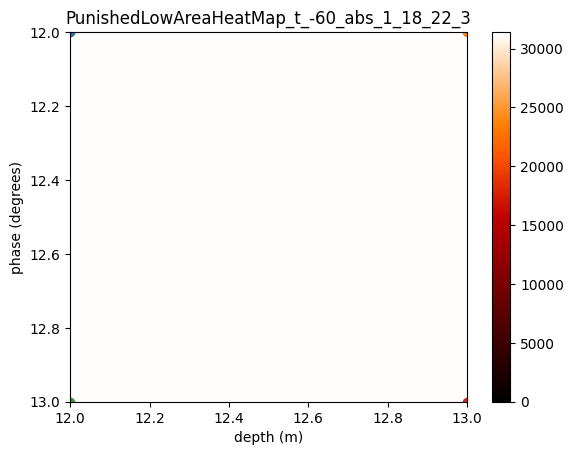

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a abs threshold of -62 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


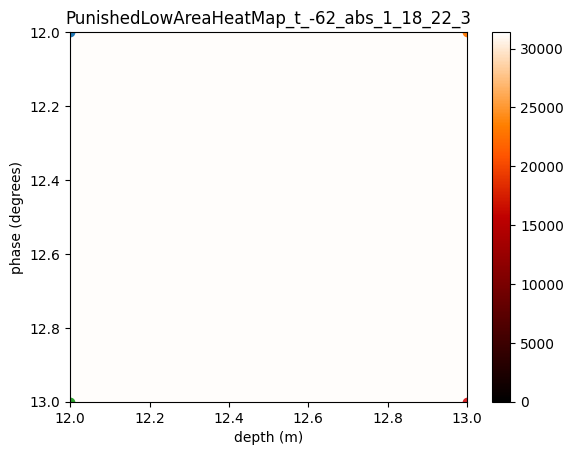

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a abs threshold of -64 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


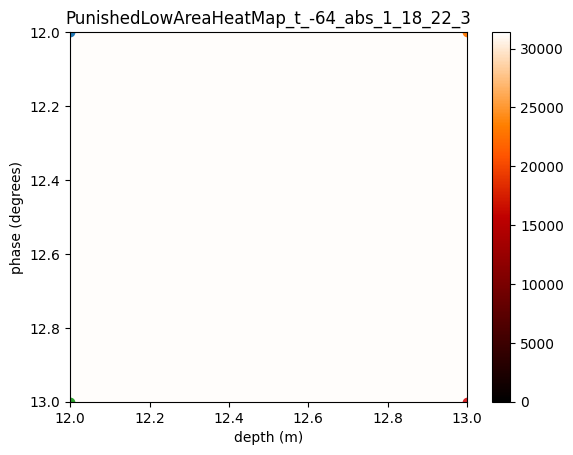

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a abs threshold of -65 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


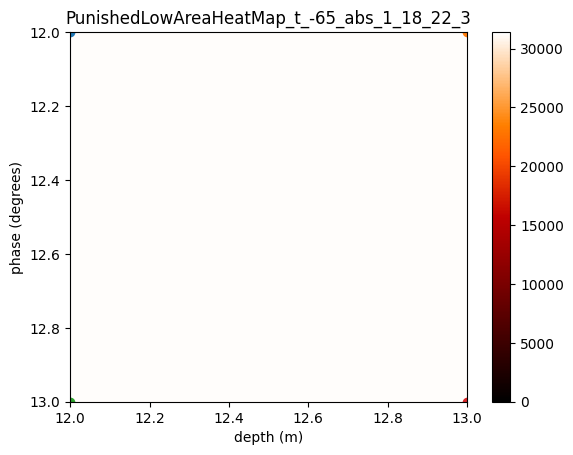

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a abs threshold of -66 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


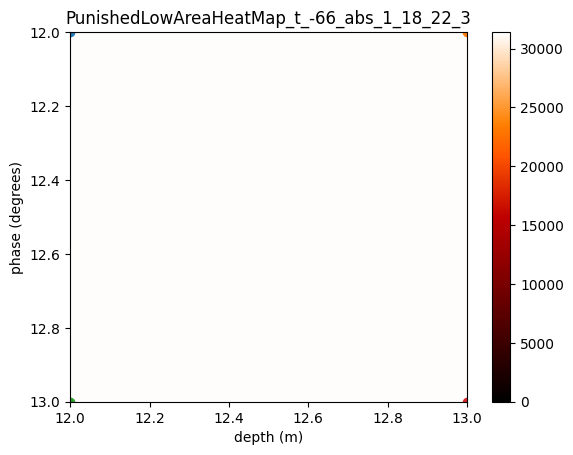

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a abs threshold of -67 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


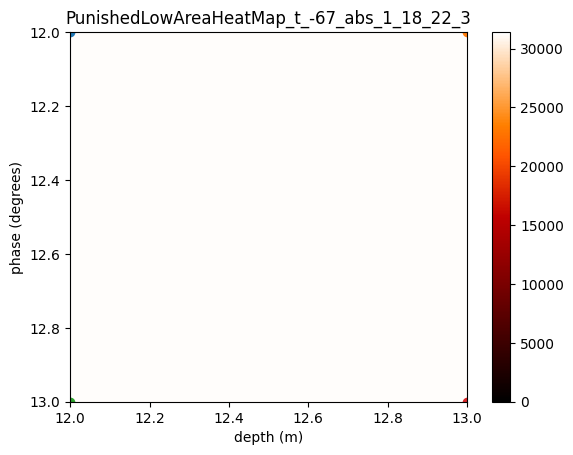

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a abs threshold of -68 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


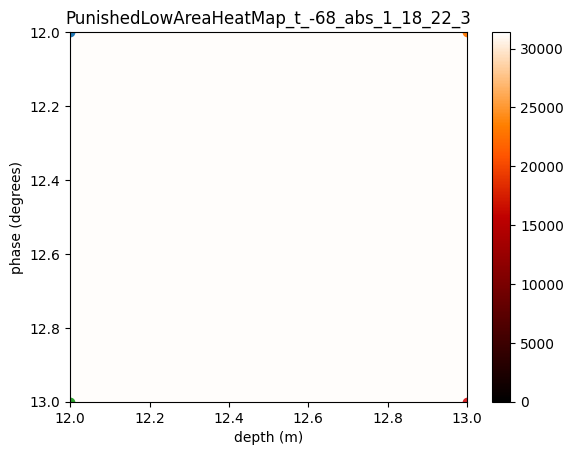

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a abs threshold of -69 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


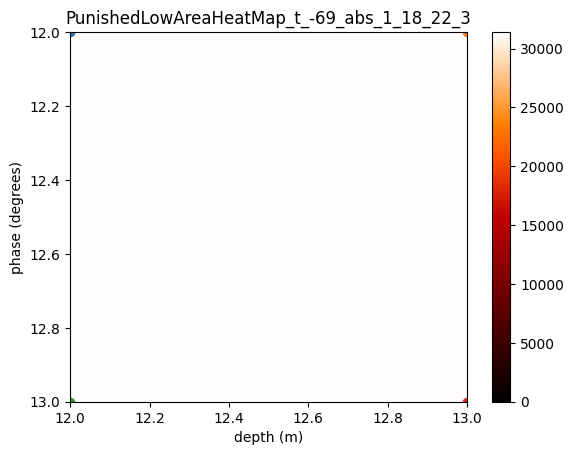

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a abs threshold of -70 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


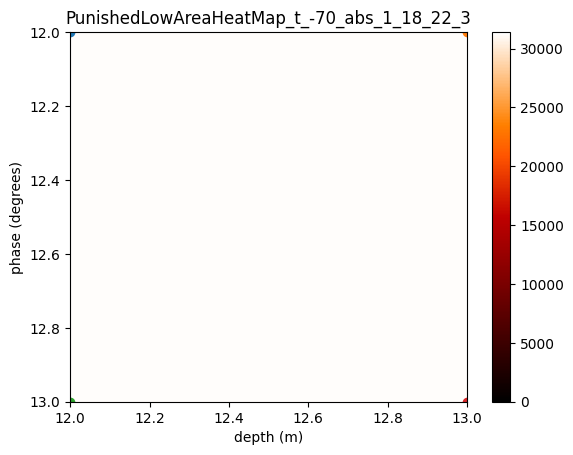

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a abs threshold of -71 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


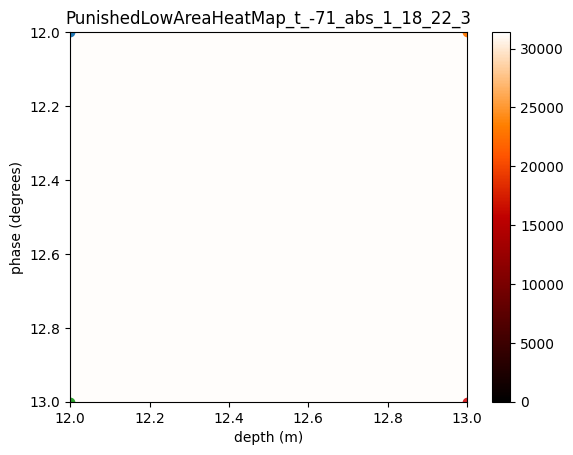

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a abs threshold of -72 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


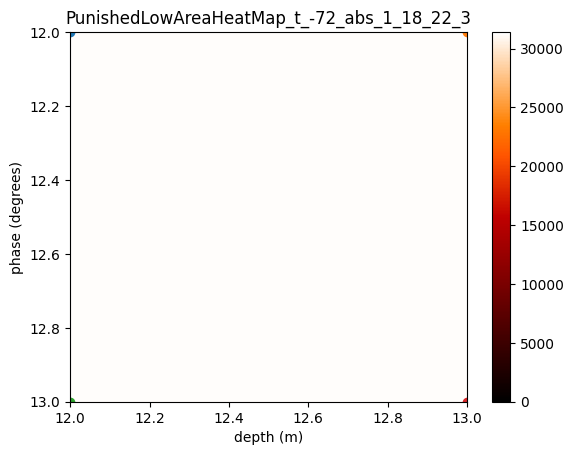

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a abs threshold of -74 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


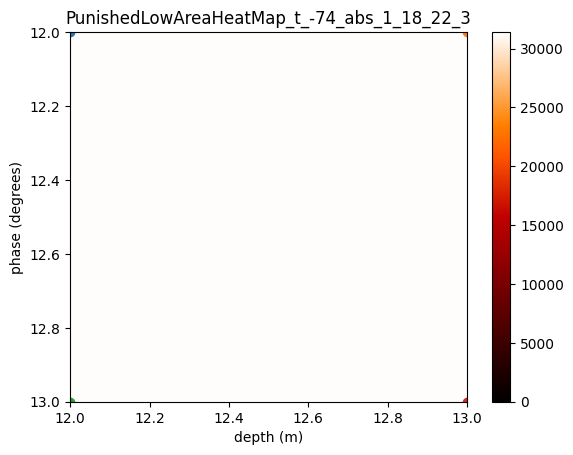

In [14]:
maxPunishedLowAbsarea = 0

for i in range(len(threshold_abss)):
    threshold_abs = threshold_abss[i]
    for a_i in range(len(a_array)):
        a = a_array[a_i]
        print("a = " + str(a))
        for d in range(len(depth_array)):
            depth_64 = depth_array[d]
            depth = float(depth_64)
            print("depth = " + str(depth))
            for p in range(len(phase_array)): 
                print("phi = " + str(phase_array[p]))
                phi = np.deg2rad(phase_array[p])

                
                ### calculate the area integral ###
                punished_low_area_integral_abs = 0
                for r_out_abs in range(column_size):
                    if r_out_abs < pixel_max:
                        if arrayESlices[p][d][a_i][r_out_abs] == 0:
                            arrayESlices[p][d][a_i][r_out_abs] = 0.0000000001
                        if threshold_abs < 10*math.log10((arrayESlices[p][d][a_i][r_out_abs])**2):
                            punished_low_area_integral_abs += r_out_abs*mpp*mpp

                punished_low_area_matrix_abs[p][d][a_i] = 2*np.pi*punished_low_area_integral_abs

                
    ### Finding the maximum area and the set(s) of parameters ###
    punished_low_area_abs_max = 0 
    maxPunishedLowAREAvaluesABS = []
    punished_low_area_phase_abs_max = 0
    punishedLowAreaMaxPHASEvaluesABS = []
    punished_low_area_depth_abs_max = 0
    punishedLowAreaMaxDEPTHvaluesABS = []
    punished_low_area_a_abs_max = 0
    punishedLowAreaMaxAvaluesABS = []
    for p in range(len(phase_array)):
        for d in range(len(depth_array)):
            for a in range(len(a_array)):
                if punished_low_area_abs_max <= punished_low_area_matrix_abs[p][d][a]:
                    maxPunishedLowAREAvaluesABS.append(punished_low_area_matrix_abs[p][d][a])
                    punished_low_area_abs_max = punished_low_area_matrix_abs[p][d][a]
                    punished_low_area_phase_abs_max = phase_array[p]
                    punishedLowAreaMaxPHASEvaluesABS.append(punished_low_area_phase_abs_max)
                    punished_low_area_depth_abs_max = depth_array[d]
                    punishedLowAreaMaxDEPTHvaluesABS.append(punished_low_area_depth_abs_max)
                    punished_low_area_a_abs_max = a_array[a]
                    punishedLowAreaMaxAvaluesABS.append(punished_low_area_a_abs_max)
     
    punished_low_area_indices_abs = []
    punishedLowAreaMaximizedAvaluesABS = []
    punishedLowAreaMaximizedDEPTHvaluesABS = []
    punishedLowAreaMaximizedPHASEvaluesABS = []
    punishedLowAreaMaximizedAREAvaluesABS = []
    
    biggest_punished_low_area_abs = max(maxPunishedLowAREAvaluesABS)

    for y in range(len(maxPunishedLowAREAvaluesABS)):
        if maxPunishedLowAREAvaluesABS[y] == biggest_punished_low_area_abs:
            punished_low_area_indices_abs.append(y)
    
    for z in punished_low_area_indices_abs:
        punishedLowAreaMaximizedAvaluesABS.append(punishedLowAreaMaxAvaluesABS[z])
        punishedLowAreaMaximizedDEPTHvaluesABS.append(punishedLowAreaMaxDEPTHvaluesABS[z])
        punishedLowAreaMaximizedPHASEvaluesABS.append(punishedLowAreaMaxPHASEvaluesABS[z])
        punishedLowAreaMaximizedAREAvaluesABS.append(maxPunishedLowAREAvaluesABS[z])

        
    ## print the best set of parameters from a threshold to the optimized data file ##
    print('The best parameters from a abs threshold of ' + str(threshold_abs) + ' are \n depth:' + str(punishedLowAreaMaximizedDEPTHvaluesABS) + '\n phase:' + str(punishedLowAreaMaximizedPHASEvaluesABS) + 
          '\n a:' + str(punishedLowAreaMaximizedAvaluesABS) + '\n with an area of:' + str(punishedLowAreaMaximizedAREAvaluesABS))
    
    if biggest_punished_low_area_abs > maxPunishedLowAbsarea:
        maxPunishedLowAbsarea = biggest_punished_low_area_abs

        
    ## plot the heat map ##
    fig, ax = plt.subplots()
    ax.set_aspect('auto')
    punished_low_area_trans_abs = np.transpose(punished_low_area_matrix_abs)
    punished_low_area_heat_map_abs = np.transpose(punished_low_area_trans_abs[0])
    # add dots for best design #    
    for _ in range(len(punished_low_area_indices_abs)):
        plt.scatter(punishedLowAreaMaximizedDEPTHvaluesABS[_],punishedLowAreaMaximizedPHASEvaluesABS[_])
    plt.imshow(punished_low_area_heat_map_abs, extent=[depth_array[0],depth_array[-1],phase_array[-1],phase_array[0]], aspect = "auto", vmin=0, vmax=31400, interpolation='spline36', cmap='gist_heat', alpha=1)
    ax.set_xlabel("depth (m)")
    ax.set_ylabel("phase (degrees)")
    plt.axis('on')
    punished_low_area_plot_title_abs = "PunishedLowAreaHeatMap_t_"+str(threshold_abs)+"_abs_"+name
    plt.title(punished_low_area_plot_title_abs)
    plt.colorbar()
    plt.show()
    fig.savefig('ThresholdPlots/PunishedLow/'+ punished_low_area_plot_title_abs +'.png') 
    
    
    ## write the best set of parameters from a threshold to the optimized data file ##
    for _ in range(len(punished_low_area_indices_abs)):
        file_punished_low_area_abs.write( "     " + str(threshold_abs) + "             " + str(punishedLowAreaMaximizedDEPTHvaluesABS[_]) + "          " + str(punishedLowAreaMaximizedPHASEvaluesABS[_]) + "          " + str(punishedLowAreaMaximizedAREAvaluesABS[_])  +'\n')
    
file_punished_low_area_abs.close()

In [15]:
### Creating a GIFs of all the heat maps from the various thresholds ###

from PIL import Image
import glob
 
# Create the frames
frames = []
imgs = glob.glob('ThresholdPlots/PunishedLow/*abs_'+ name +'.png')
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 
# Save into a GIF file that loops forever
frames[0].save('ThresholdPlots/GIFs/PunishedLowAnimationAbs_'+name+'.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

## Punished area from long range detector dBd

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 6 are 
 depth:[12, 12]
 phase:[12, 13]
 a:[100000, 100000]
 with an area of:[1452.9866022852793, 1452.9866022852793]


/var/folders/7c/ctd744mx4bjchcjkw9s71m1r0000gn/T/ipykernel_50625/3727240752.py:21: RuntimeWarning: invalid value encountered in double_scalars
  if (arrayNormESlices[p][d][a_i][r_out_dBd]/dipoleNormESlices[d][a_i][r_out_dBd])**2 <= 0:
/var/folders/7c/ctd744mx4bjchcjkw9s71m1r0000gn/T/ipykernel_50625/3727240752.py:24: RuntimeWarning: invalid value encountered in double_scalars
  if threshold_dBd < 10*math.log10((arrayNormESlices[p][d][a_i][r_out_dBd]/dipoleNormESlices[d][a_i][r_out_dBd])**2):


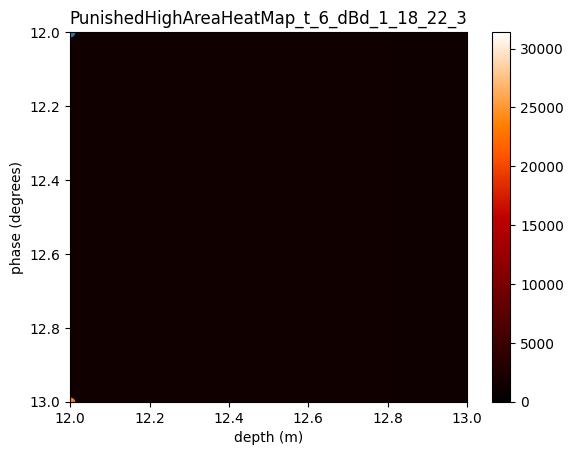

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 5 are 
 depth:[13]
 phase:[13]
 a:[100000]
 with an area of:[1812.6989611213107]


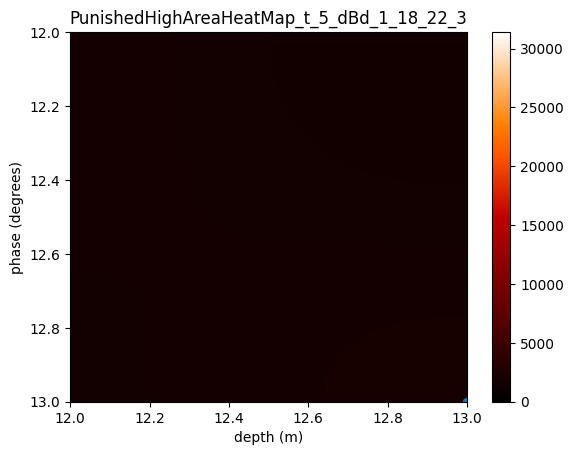

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 4 are 
 depth:[12, 12]
 phase:[12, 13]
 a:[100000, 100000]
 with an area of:[1899.09275909503, 1899.09275909503]


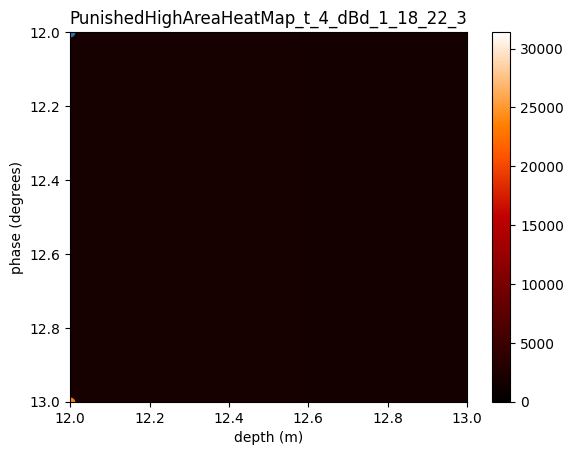

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 3 are 
 depth:[13]
 phase:[13]
 a:[100000]
 with an area of:[2445.7298808196538]


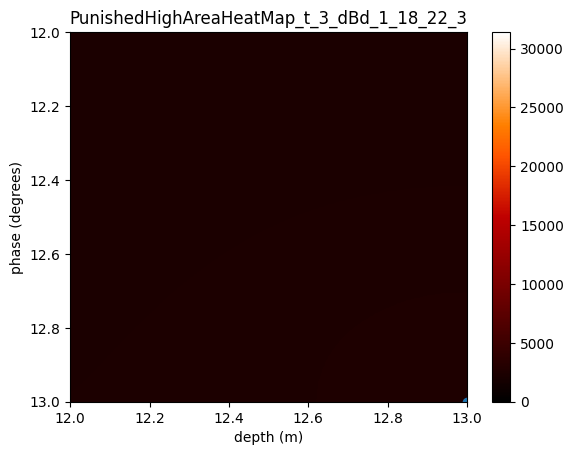

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 2 are 
 depth:[13]
 phase:[13]
 a:[100000]
 with an area of:[2924.8227604920976]


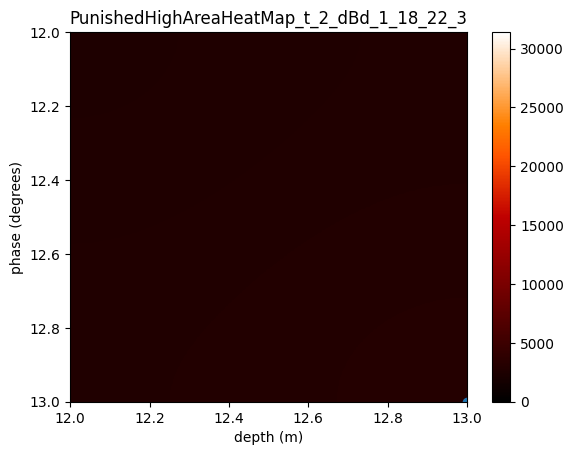

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 1 are 
 depth:[13]
 phase:[13]
 a:[100000]
 with an area of:[3747.920035732623]


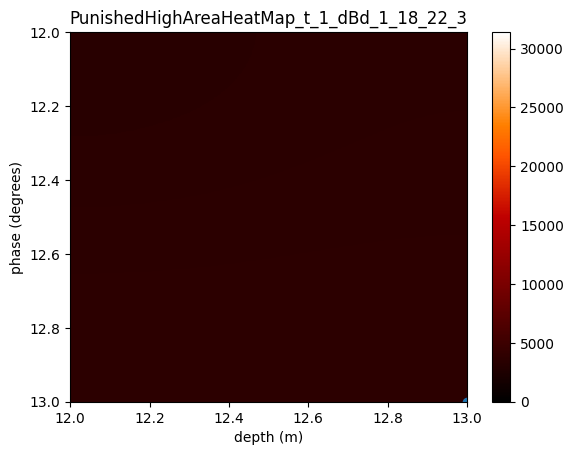

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 0 are 
 depth:[12]
 phase:[13]
 a:[100000]
 with an area of:[4710.8181840578945]


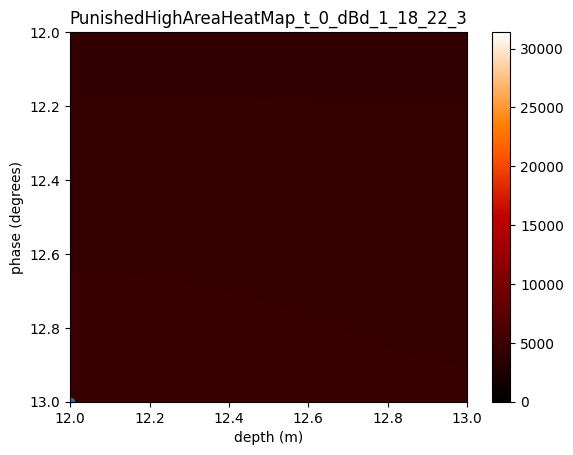

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of -1 are 
 depth:[12]
 phase:[13]
 a:[100000]
 with an area of:[6701.017130107029]


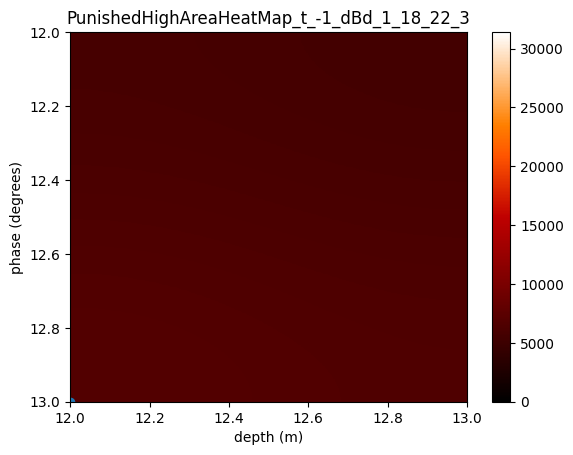

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of -2 are 
 depth:[12]
 phase:[13]
 a:[100000]
 with an area of:[9919.578803709772]


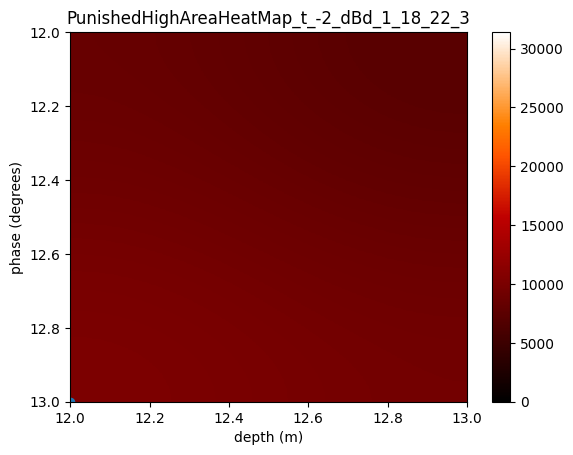

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of -3 are 
 depth:[12]
 phase:[13]
 a:[100000]
 with an area of:[20165.883243392884]


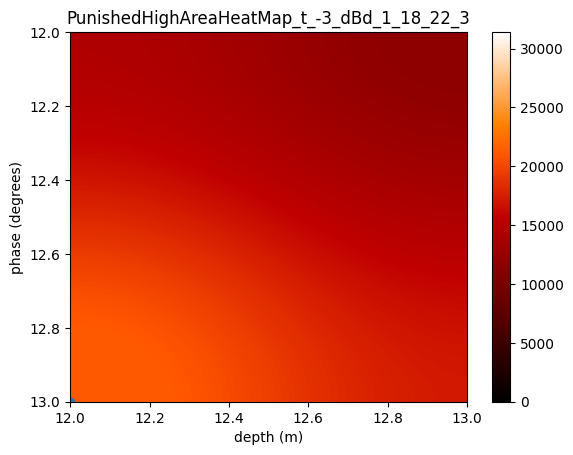

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of -4 are 
 depth:[12]
 phase:[13]
 a:[100000]
 with an area of:[25966.834078246437]


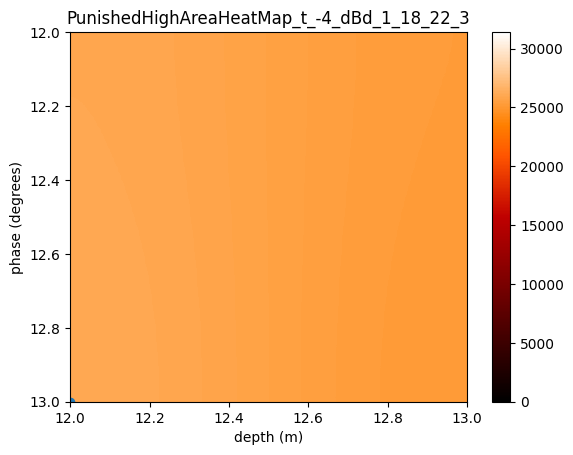

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of -5 are 
 depth:[12]
 phase:[13]
 a:[100000]
 with an area of:[26618.714553866317]


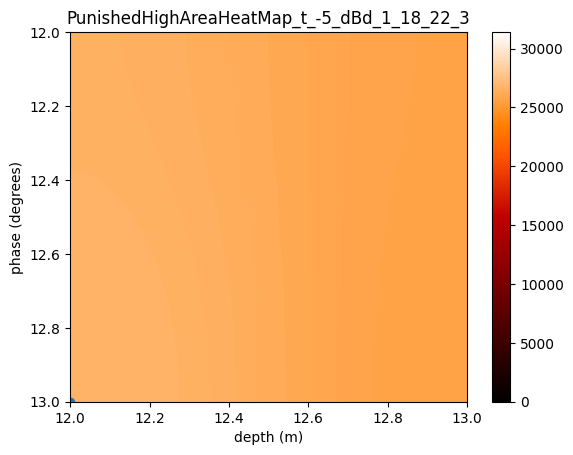

In [16]:
maxPunishedHighdBdarea = 0

for i in range(len(threshold_dBds)):
    threshold_dBd = threshold_dBds[i]
    for a_i in range(len(a_array)):
        a = a_array[a_i]
        print("a = " + str(a))
        for d in range(len(depth_array)):
            depth_64 = depth_array[d]
            depth = float(depth_64)
            print("depth = " + str(depth))
            for p in range(len(phase_array)): 
                print("phi = " + str(phase_array[p]))
                phi = np.deg2rad(phase_array[p])

                
                ### calculate the area integral ###
                punished_high_area_integral_dBd = 0
                for r_out_dBd in range(column_size):
                    if r_out_dBd < pixel_max:
                        if (arrayNormESlices[p][d][a_i][r_out_dBd]/dipoleNormESlices[d][a_i][r_out_dBd])**2 <= 0:
                            arrayNormESlices[p][d][a_i][round(r_out_dBd)] = 0.0000000000001
                            dipoleNormESlices[d][a_i][round(r_out_dBd)] = 1
                        if threshold_dBd < 10*math.log10((arrayNormESlices[p][d][a_i][r_out_dBd]/dipoleNormESlices[d][a_i][r_out_dBd])**2):
                            punished_high_area_integral_dBd += r_out_dBd*mpp*mpp

                punished_high_area_matrix_dBd[p][d][a_i] = 2*np.pi*punished_high_area_integral_dBd

                
    ### Finding the maximum area and the set(s) of parameters ###
    punished_high_area_dBd_max = 0 
    maxPunishedHighAREAvaluesDBD = []
    punished_high_area_phase_dBd_max = 0
    punishedHighAreaMaxPHASEvaluesDBD = []
    punished_high_area_depth_dBd_max = 0
    punishedHighAreaMaxDEPTHvaluesDBD = []
    punished_high_area_a_dBd_max = 0
    punishedHighAreaMaxAvaluesDBD = []
    for p in range(len(phase_array)):
        for d in range(len(depth_array)):
            for a in range(len(a_array)):
                if punished_high_area_dBd_max <= punished_high_area_matrix_dBd[p][d][a]:
                    maxPunishedHighAREAvaluesDBD.append(punished_high_area_matrix_dBd[p][d][a])
                    punished_high_area_dBd_max = punished_high_area_matrix_dBd[p][d][a]
                    punished_high_area_phase_dBd_max = phase_array[p]
                    punishedHighAreaMaxPHASEvaluesDBD.append(punished_high_area_phase_dBd_max)
                    punished_high_area_depth_dBd_max = depth_array[d]
                    punishedHighAreaMaxDEPTHvaluesDBD.append(punished_high_area_depth_dBd_max)
                    punished_high_area_a_dBd_max = a_array[a]
                    punishedHighAreaMaxAvaluesDBD.append(punished_high_area_a_dBd_max)
     
    punished_high_area_indices_dBd = []
    punishedHighAreaMaximizedAvaluesDBD = []
    punishedHighAreaMaximizedDEPTHvaluesDBD = []
    punishedHighAreaMaximizedPHASEvaluesDBD = []
    punishedHighAreaMaximizedAREAvaluesDBD = []
    
    biggest_punished_high_area_dBd = max(maxPunishedHighAREAvaluesDBD)

    for y in range(len(maxPunishedHighAREAvaluesDBD)):
        if maxPunishedHighAREAvaluesDBD[y] == biggest_punished_high_area_dBd:
            punished_high_area_indices_dBd.append(y)
    
    for z in punished_high_area_indices_dBd:
        punishedHighAreaMaximizedAvaluesDBD.append(punishedHighAreaMaxAvaluesDBD[z])
        punishedHighAreaMaximizedDEPTHvaluesDBD.append(punishedHighAreaMaxDEPTHvaluesDBD[z])
        punishedHighAreaMaximizedPHASEvaluesDBD.append(punishedHighAreaMaxPHASEvaluesDBD[z])
        punishedHighAreaMaximizedAREAvaluesDBD.append(maxPunishedHighAREAvaluesDBD[z])
    
    
    ## print the best set of parameters from a threshold to the optimized data file ##
    print('The best parameters from a dBd threshold of ' + str(threshold_dBd) + ' are \n depth:' + str(punishedHighAreaMaximizedDEPTHvaluesDBD) + '\n phase:' + str(punishedHighAreaMaximizedPHASEvaluesDBD) + 
          '\n a:' + str(punishedHighAreaMaximizedAvaluesDBD) + '\n with an area of:' + str(punishedHighAreaMaximizedAREAvaluesDBD))

    if biggest_punished_high_area_dBd > maxPunishedHighdBdarea:
        maxPunishedHighdBdarea = biggest_punished_high_area_dBd

        
    ## plot the heat map ##
    fig, ax = plt.subplots()
    ax.set_aspect('auto')
    punished_high_area_trans_dBd = np.transpose(punished_high_area_matrix_dBd)
    punished_high_area_heat_map_dBd = np.transpose(punished_high_area_trans_dBd[0])
    # add dots for best design #
    for _ in range(len(punished_high_area_indices_dBd)):
        plt.scatter(punishedHighAreaMaximizedDEPTHvaluesDBD[_],punishedHighAreaMaximizedPHASEvaluesDBD[_])
    plt.imshow(punished_high_area_heat_map_dBd, extent=[depth_array[0],depth_array[-1],phase_array[-1],phase_array[0]], aspect = "auto", vmin=0, vmax=31400, interpolation='spline36', cmap='gist_heat', alpha=1)                
    ax.set_xlabel("depth (m)")
    ax.set_ylabel("phase (degrees)")
    plt.axis('on')
    punished_high_area_plot_title_dBd = "PunishedHighAreaHeatMap_t_"+str(threshold_dBd)+"_dBd_"+name
    plt.title(punished_high_area_plot_title_dBd)
    plt.colorbar()
    plt.show()
    fig.savefig('ThresholdPlots/PunishedHigh/'+punished_high_area_plot_title_dBd+'.png')                  

    
    ## write the best set of parameters from a threshold to the optimized data file ##
    for _ in range(len(punished_high_area_indices_dBd)):
        file_punished_high_area_dBd.write( "     " + str(threshold_dBd) + "             " + str(punishedHighAreaMaximizedDEPTHvaluesDBD[_]) + "          " + str(punishedHighAreaMaximizedPHASEvaluesDBD[_]) + "          " + str(punishedHighAreaMaximizedAREAvaluesDBD[_])  +'\n')
    
file_punished_high_area_dBd.close()

In [17]:
### Creating a GIFs of all the heat maps from the various thresholds ###

from PIL import Image
import glob
 
# Create the frames
frames = []
imgs = glob.glob('ThresholdPlots/PunishedHigh/*dBd_'+ name +'.png')
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 
# Save into a GIF file that loops forever
frames[0].save('ThresholdPlots/GIFs/PunishedHighAnimationdBd_'+name+'.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

## Punished area from long range detector Abs

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from an abs threshold of -60 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


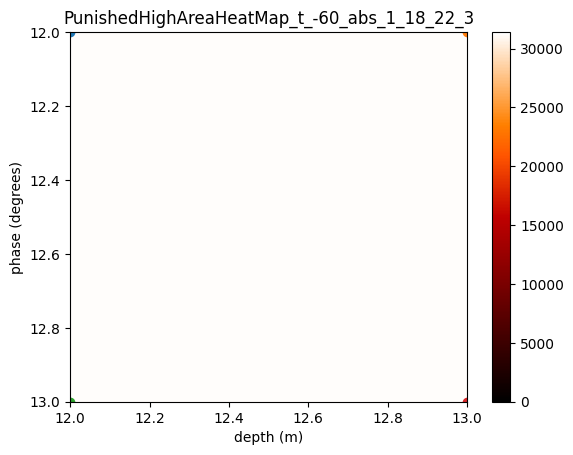

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from an abs threshold of -62 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


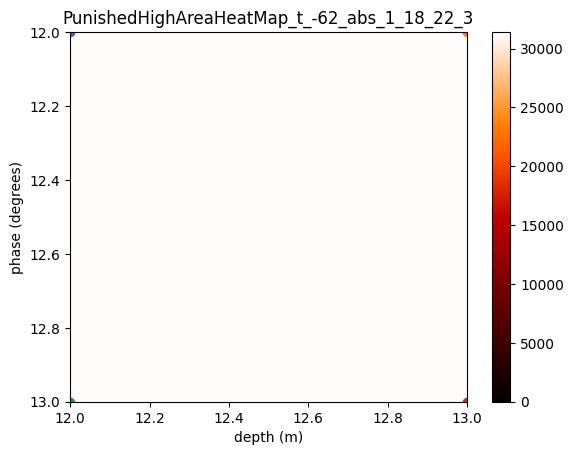

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from an abs threshold of -64 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


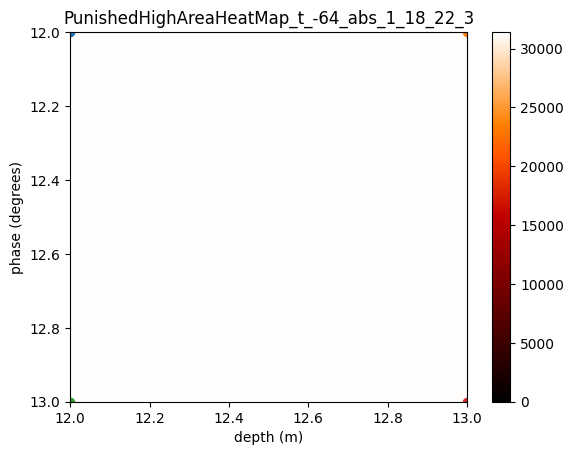

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from an abs threshold of -65 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


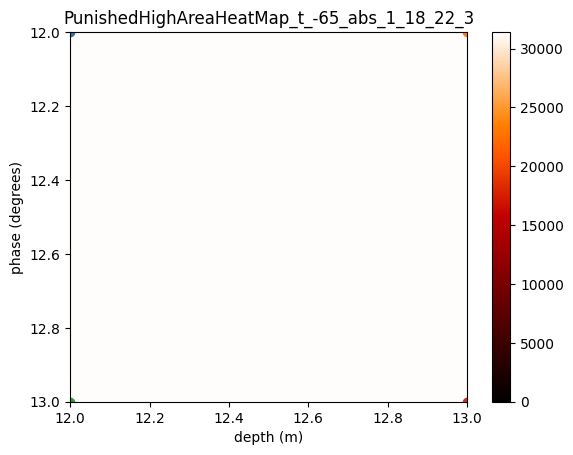

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from an abs threshold of -66 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


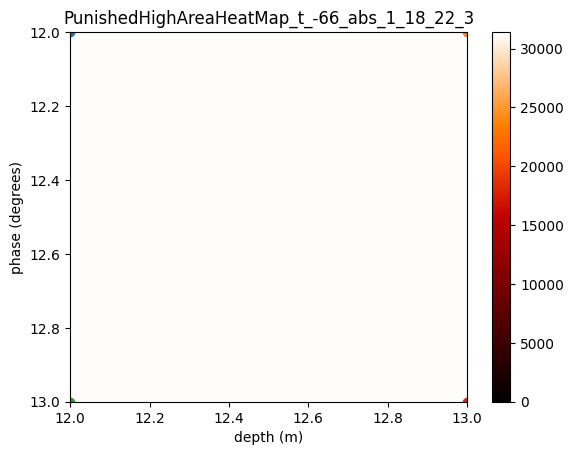

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from an abs threshold of -67 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


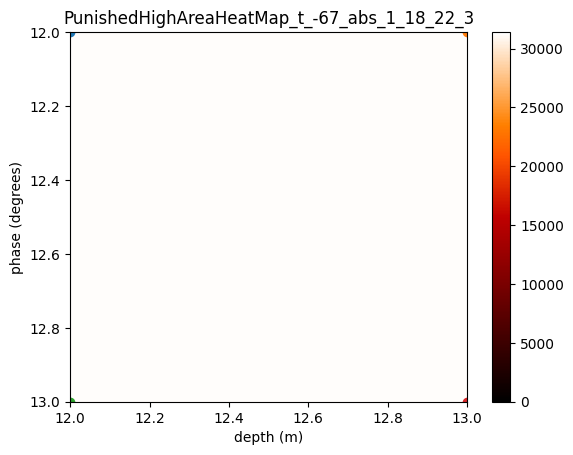

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from an abs threshold of -68 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


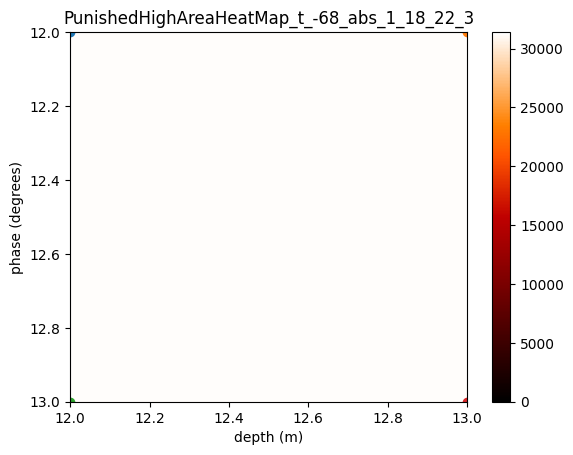

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from an abs threshold of -69 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


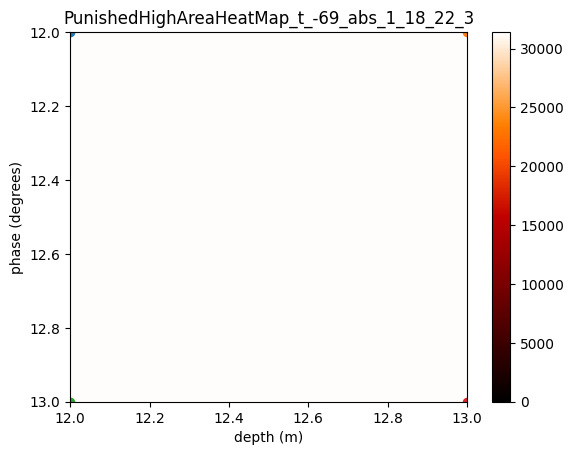

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from an abs threshold of -70 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


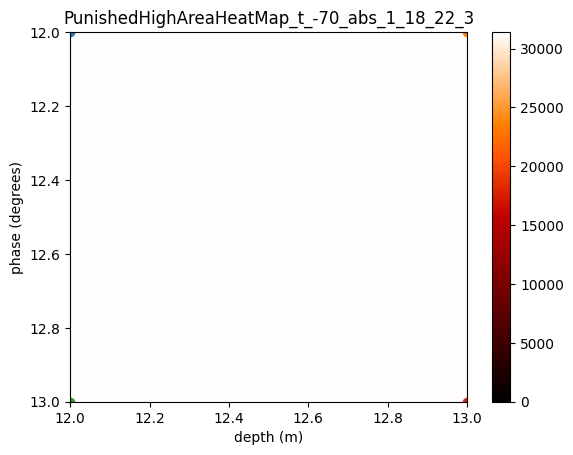

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from an abs threshold of -71 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


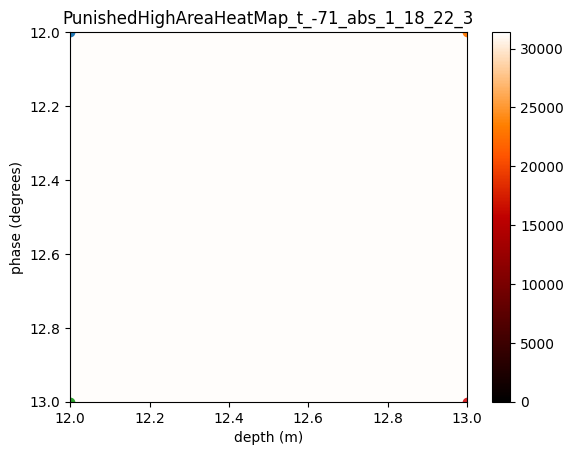

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from an abs threshold of -72 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


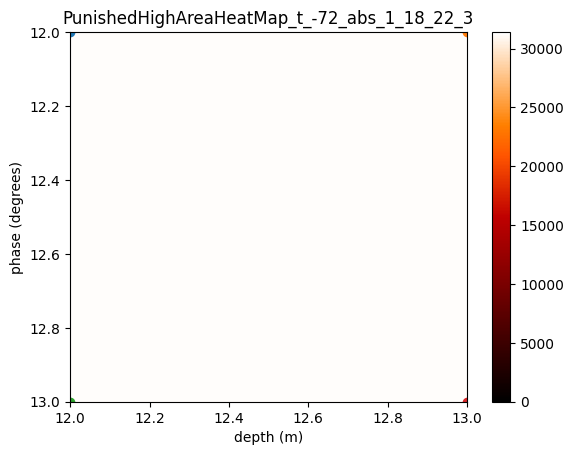

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from an abs threshold of -74 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


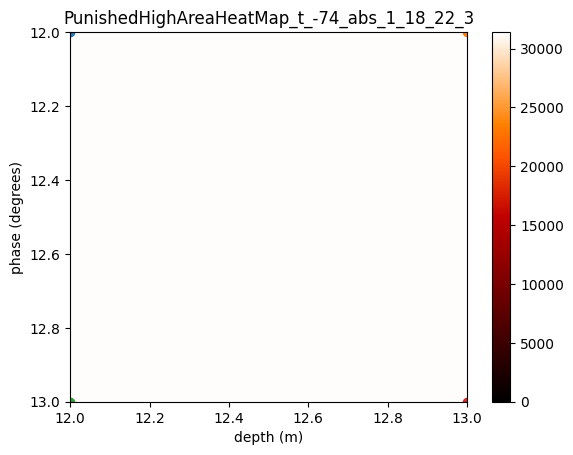

In [18]:
maxPunishedHighAbsarea = 0

for i in range(len(threshold_abss)):
    threshold_abs = threshold_abss[i]
    for a_i in range(len(a_array)):
        a = a_array[a_i]
        print("a = " + str(a))
        for d in range(len(depth_array)):
            depth_64 = depth_array[d]
            depth = float(depth_64)
            print("depth = " + str(depth))
            for p in range(len(phase_array)): 
                print("phi = " + str(phase_array[p]))
                phi = np.deg2rad(phase_array[p])

                
                ### calculate the area integral ###
                punished_high_area_integral_abs = 0
                for r_out_abs in range(column_size):
                    if r_out_abs < pixel_max:
                        if arrayESlices[p][d][a_i][r_out_abs] == 0:
                            arrayESlices[p][d][a_i][r_out_abs] = 0.0000000001
                        if threshold_abs < 10*math.log10((arrayESlices[p][d][a_i][r_out_abs])**2):
                            punished_high_area_integral_abs += r_out_abs*mpp*mpp

                punished_high_area_matrix_abs[p][d][a_i] = 2*np.pi*punished_high_area_integral_abs

                
    ### Finding the maximum area and the set(s) of parameters ###
    punished_high_area_abs_max = 0 
    maxPunishedHighAREAvaluesABS = []
    punished_high_area_phase_abs_max = 0
    punishedHighAreaMaxPHASEvaluesABS = []
    punished_high_area_depth_abs_max = 0
    punishedHighAreaMaxDEPTHvaluesABS = []
    punished_high_area_a_abs_max = 0
    punishedHighAreaMaxAvaluesABS = []
    for p in range(len(phase_array)):
        for d in range(len(depth_array)):
            for a in range(len(a_array)):
                if punished_high_area_abs_max <= punished_high_area_matrix_abs[p][d][a]:
                    maxPunishedHighAREAvaluesABS.append(punished_high_area_matrix_abs[p][d][a])
                    punished_high_area_abs_max = punished_high_area_matrix_abs[p][d][a]
                    punished_high_area_phase_abs_max = phase_array[p]
                    punishedHighAreaMaxPHASEvaluesABS.append(punished_high_area_phase_abs_max)
                    punished_high_area_depth_abs_max = depth_array[d]
                    punishedHighAreaMaxDEPTHvaluesABS.append(punished_high_area_depth_abs_max)
                    punished_high_area_a_abs_max = a_array[a]
                    punishedHighAreaMaxAvaluesABS.append(punished_high_area_a_abs_max)
     
    punished_high_area_indices_abs = []
    punishedHighAreaMaximizedAvaluesABS = []
    punishedHighAreaMaximizedDEPTHvaluesABS = []
    punishedHighAreaMaximizedPHASEvaluesABS = []
    punishedHighAreaMaximizedAREAvaluesABS = []
    
    biggest_punished_high_area_abs = max(maxPunishedHighAREAvaluesABS)

    for y in range(len(maxPunishedHighAREAvaluesABS)):
        if maxPunishedHighAREAvaluesABS[y] == biggest_punished_high_area_abs:
            punished_high_area_indices_abs.append(y)
    
    for z in punished_high_area_indices_abs:
        punishedHighAreaMaximizedAvaluesABS.append(punishedHighAreaMaxAvaluesABS[z])
        punishedHighAreaMaximizedDEPTHvaluesABS.append(punishedHighAreaMaxDEPTHvaluesABS[z])
        punishedHighAreaMaximizedPHASEvaluesABS.append(punishedHighAreaMaxPHASEvaluesABS[z])
        punishedHighAreaMaximizedAREAvaluesABS.append(maxPunishedHighAREAvaluesABS[z])
   

    ## print the best set of parameters from a threshold to the optimized data file ##
    print('The best parameters from an abs threshold of ' + str(threshold_abs) + ' are \n depth:' + str(punishedHighAreaMaximizedDEPTHvaluesABS) + '\n phase:' + str(punishedHighAreaMaximizedPHASEvaluesABS) + 
          '\n a:' + str(punishedHighAreaMaximizedAvaluesABS) + '\n with an area of:' + str(punishedHighAreaMaximizedAREAvaluesABS))

    if biggest_punished_high_area_abs > maxPunishedHighAbsarea:
        maxPunishedHighAbsarea = biggest_punished_high_area_abs

        
    ## plot the heat map ##
    fig, ax = plt.subplots()
    ax.set_aspect('auto')
    punished_high_area_trans_abs = np.transpose(punished_high_area_matrix_abs)
    punished_high_area_heat_map_abs = np.transpose(punished_high_area_trans_abs[0])
    # add dots for best design #
    for _ in range(len(punished_high_area_indices_abs)):
        plt.scatter(punishedHighAreaMaximizedDEPTHvaluesABS[_],punishedHighAreaMaximizedPHASEvaluesABS[_])
    plt.imshow(punished_high_area_heat_map_abs, extent=[depth_array[0],depth_array[-1],phase_array[-1],phase_array[0]], aspect = "auto", vmin=0, vmax=31400, interpolation='spline36', cmap='gist_heat', alpha=1)
    ax.set_xlabel("depth (m)")
    ax.set_ylabel("phase (degrees)")
    plt.axis('on')
    punished_high_area_plot_title_abs = "PunishedHighAreaHeatMap_t_"+str(threshold_abs)+"_abs_"+name
    plt.title(punished_high_area_plot_title_abs)
    plt.colorbar()
    plt.show()
    fig.savefig('ThresholdPlots/PunishedHigh/'+ punished_high_area_plot_title_abs +'.png') 
   

    ## write the best set of parameters from a threshold to the optimized data file ##
    for _ in range(len(punished_high_area_indices_abs)):
        file_punished_high_area_abs.write( "     " + str(threshold_abs) + "             " + str(punishedHighAreaMaximizedDEPTHvaluesABS[_]) + "          " + str(punishedHighAreaMaximizedPHASEvaluesABS[_]) + "          " + str(punishedHighAreaMaximizedAREAvaluesABS[_])  +'\n')
    
file_punished_high_area_abs.close()

In [19]:
### Creating a GIFs of all the heat maps from the various thresholds ###

from PIL import Image
import glob
 
# Create the frames
frames = []
imgs = glob.glob('ThresholdPlots/PunishedHigh/*abs_'+ name +'.png')
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 
# Save into a GIF file that loops forever
frames[0].save('ThresholdPlots/GIFs/PunishedHighAnimationAbs_'+name+'.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

## Averaged punished area from both detectors dBd

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 6 are 
 depth:[12, 12]
 phase:[12, 13]
 a:[100000, 100000]
 with an area of:[1452.9866022852793, 1452.9866022852793]


/var/folders/7c/ctd744mx4bjchcjkw9s71m1r0000gn/T/ipykernel_50625/888850696.py:20: RuntimeWarning: invalid value encountered in double_scalars
  if (arrayNormESlices[p][d][a_i][r_out_dBd]/dipoleNormESlices[d][a_i][r_out_dBd])**2 <= 0:
/var/folders/7c/ctd744mx4bjchcjkw9s71m1r0000gn/T/ipykernel_50625/888850696.py:23: RuntimeWarning: invalid value encountered in double_scalars
  if threshold_dBd < 10*math.log10((arrayNormESlices[p][d][a_i][r_out_dBd]/dipoleNormESlices[d][a_i][r_out_dBd])**2):


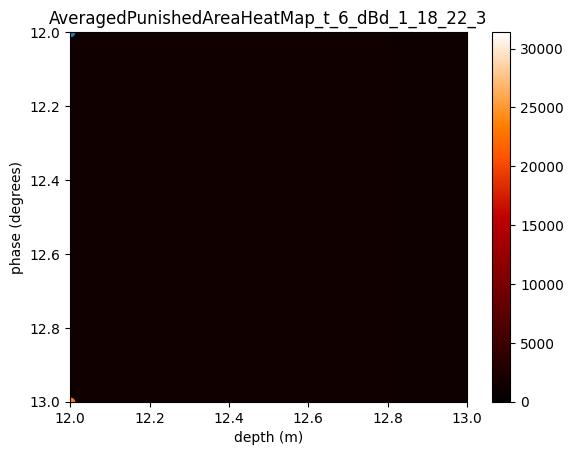

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 5 are 
 depth:[13]
 phase:[13]
 a:[100000]
 with an area of:[1812.6989611213107]


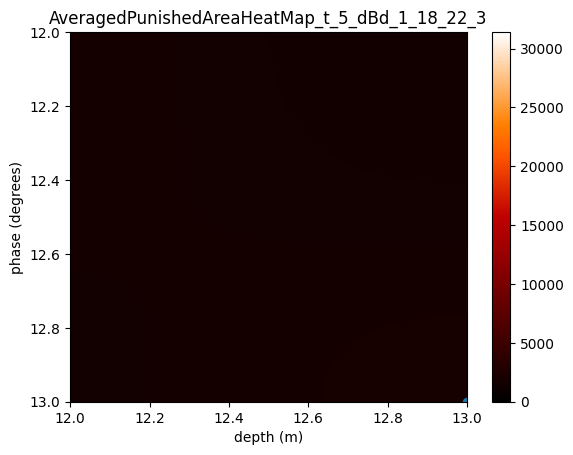

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 4 are 
 depth:[12, 12]
 phase:[12, 13]
 a:[100000, 100000]
 with an area of:[1899.09275909503, 1899.09275909503]


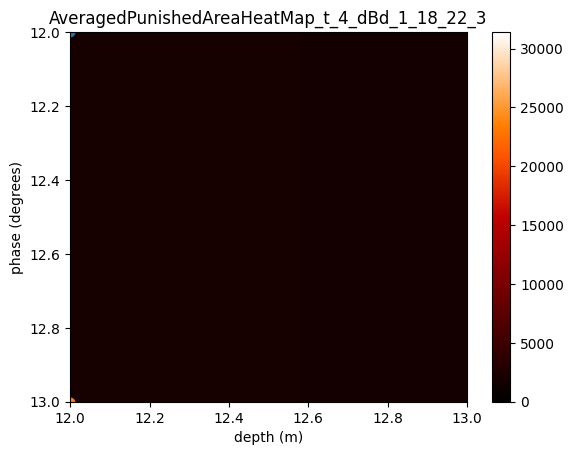

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 3 are 
 depth:[13]
 phase:[13]
 a:[100000]
 with an area of:[2445.7298808196538]


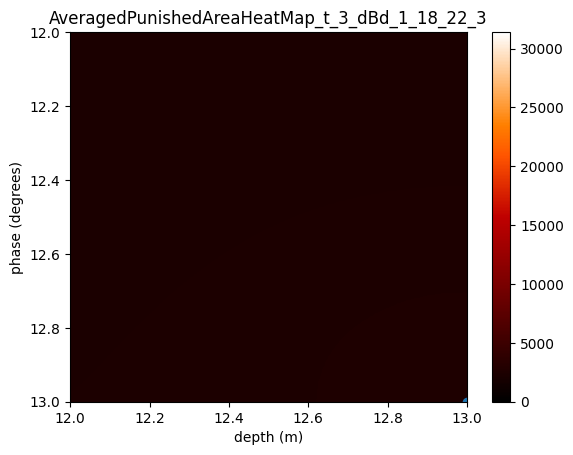

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 2 are 
 depth:[13]
 phase:[13]
 a:[100000]
 with an area of:[2924.8227604920976]


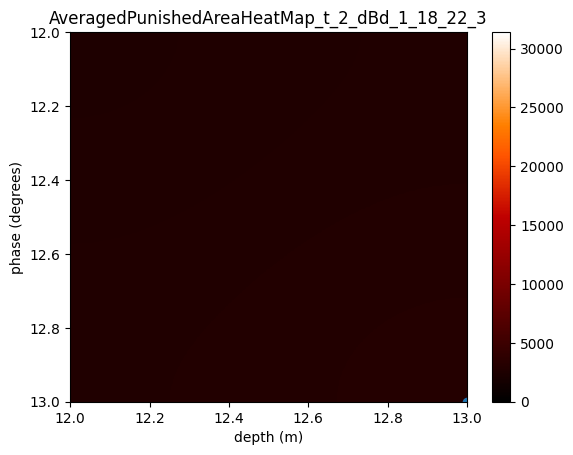

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 1 are 
 depth:[13]
 phase:[13]
 a:[100000]
 with an area of:[3747.920035732623]


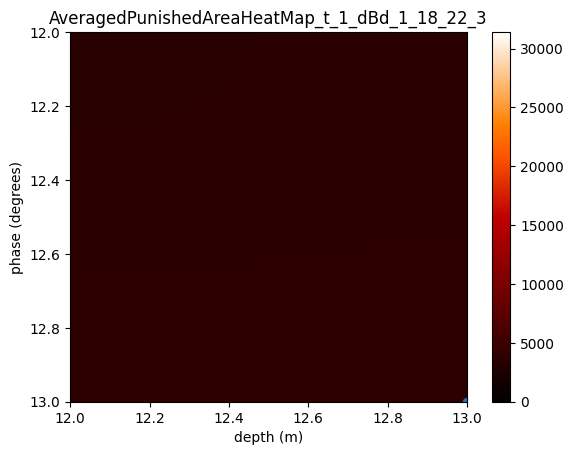

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of 0 are 
 depth:[12]
 phase:[13]
 a:[100000]
 with an area of:[4710.8181840578945]


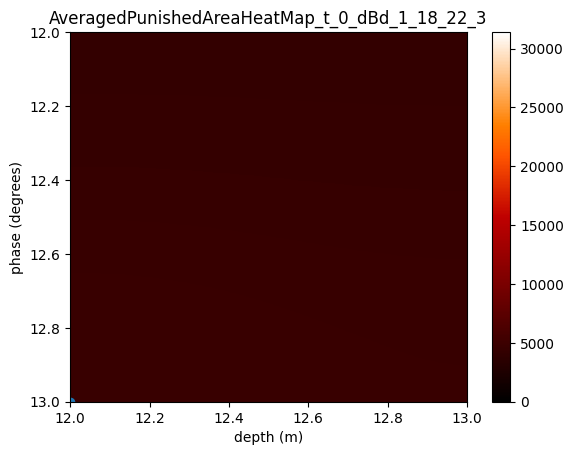

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of -1 are 
 depth:[12]
 phase:[13]
 a:[100000]
 with an area of:[6701.017130107029]


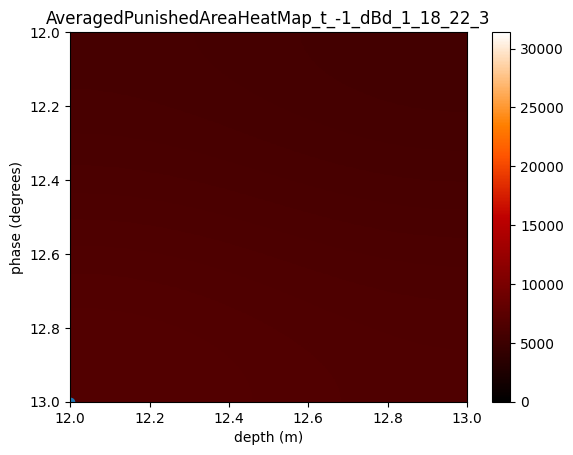

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of -2 are 
 depth:[12]
 phase:[13]
 a:[100000]
 with an area of:[9919.578803709772]


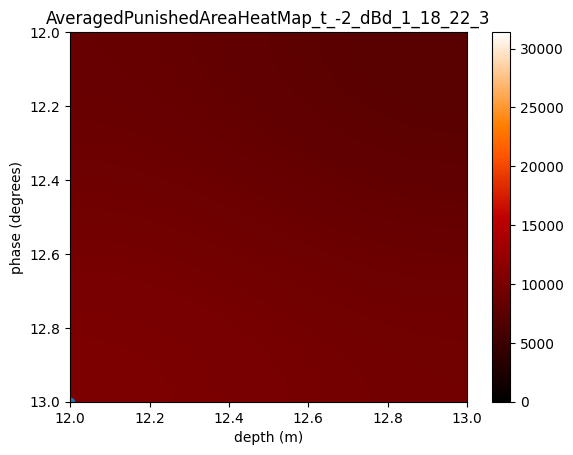

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of -3 are 
 depth:[12]
 phase:[13]
 a:[100000]
 with an area of:[20165.883243392884]


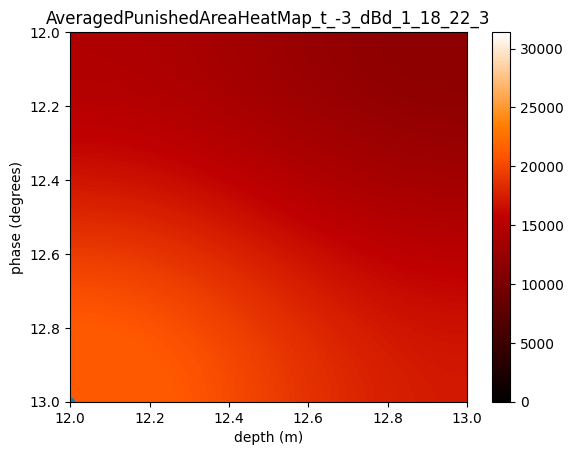

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of -4 are 
 depth:[12]
 phase:[13]
 a:[100000]
 with an area of:[25966.834078246437]


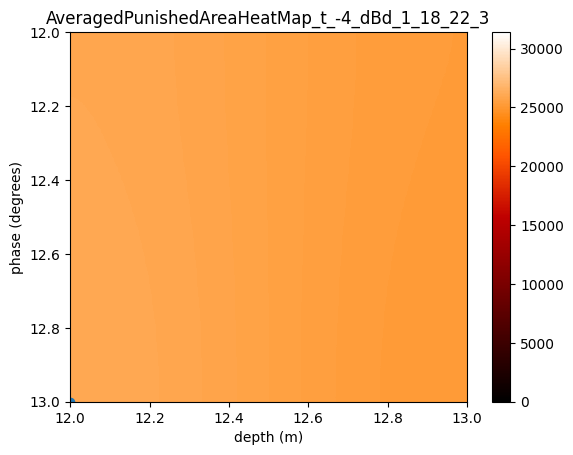

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from a dBd threshold of -5 are 
 depth:[12]
 phase:[13]
 a:[100000]
 with an area of:[26618.714553866317]


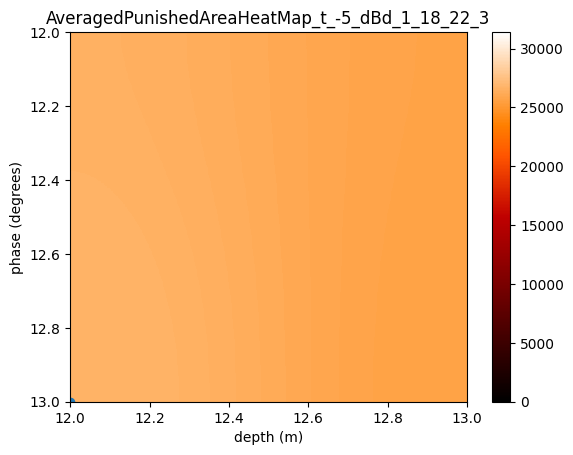

In [20]:
maxAveragedPunisheddBdarea = 0

for i in range(len(threshold_dBds)):
    threshold_dBd = threshold_dBds[i]
    for a_i in range(len(a_array)):
        a = a_array[a_i]
        print("a = " + str(a))
        for d in range(len(depth_array)):
            depth_64 = depth_array[d]
            depth = float(depth_64)
            print("depth = " + str(depth))
            for p in range(len(phase_array)): 
                print("phi = " + str(phase_array[p]))
                phi = np.deg2rad(phase_array[p])

                #### calculate the area integral ####
                averaged_punished_area_integral_dBd = 0
                for r_out_dBd in range(column_size):
                    if r_out_dBd < pixel_max:
                        if (arrayNormESlices[p][d][a_i][r_out_dBd]/dipoleNormESlices[d][a_i][r_out_dBd])**2 <= 0:
                            arrayNormESlices[p][d][a_i][r_out_dBd] = 0.0000000000001
                            dipoleNormESlices[d][a_i][r_out_dBd] = 1
                        if threshold_dBd < 10*math.log10((arrayNormESlices[p][d][a_i][r_out_dBd]/dipoleNormESlices[d][a_i][r_out_dBd])**2):
                            averaged_punished_area_integral_dBd += r_out_dBd*mpp*mpp

                averaged_punished_area_matrix_dBd[p][d][a_i] = 2*np.pi*averaged_punished_area_integral_dBd

                
    ### Finding the maximum area and the set(s) of parameters ###
    averaged_punished_area_dBd_max = 0 
    maxAveragedPunishedAREAvaluesDBD = []
    averaged_punished_area_phase_dBd_max = 0
    averagedPunishedAreaMaxPHASEvaluesDBD = []
    averaged_punished_area_depth_dBd_max = 0
    averagedPunishedAreaMaxDEPTHvaluesDBD = []
    averaged_punished_area_a_dBd_max = 0
    averagedPunishedAreaMaxAvaluesDBD = []
    for p in range(len(phase_array)):
        for d in range(len(depth_array)):
            for a in range(len(a_array)):
                if averaged_punished_area_dBd_max <= averaged_punished_area_matrix_dBd[p][d][a]:
                    maxAveragedPunishedAREAvaluesDBD.append(averaged_punished_area_matrix_dBd[p][d][a])
                    averaged_punished_area_dBd_max = averaged_punished_area_matrix_dBd[p][d][a]
                    averaged_punished_area_phase_dBd_max = phase_array[p]
                    averagedPunishedAreaMaxPHASEvaluesDBD.append(averaged_punished_area_phase_dBd_max)
                    averaged_punished_area_depth_dBd_max = depth_array[d]
                    averagedPunishedAreaMaxDEPTHvaluesDBD.append(averaged_punished_area_depth_dBd_max)
                    averaged_punished_area_a_dBd_max = a_array[a]
                    averagedPunishedAreaMaxAvaluesDBD.append(averaged_punished_area_a_dBd_max)
     
    averaged_punished_area_indices_dBd = []
    averagedPunishedAreaMaximizedAvaluesDBD = []
    averagedPunishedAreaMaximizedDEPTHvaluesDBD = []
    averagedPunishedAreaMaximizedPHASEvaluesDBD = []
    averagedPunishedAreaMaximizedAREAvaluesDBD = []
    
    biggest_averaged_punished_area_dBd = max(maxAveragedPunishedAREAvaluesDBD)

    for y in range(len(maxAveragedPunishedAREAvaluesDBD)):
        if maxAveragedPunishedAREAvaluesDBD[y] == biggest_averaged_punished_area_dBd:
            averaged_punished_area_indices_dBd.append(y)
    
    for z in averaged_punished_area_indices_dBd:
        averagedPunishedAreaMaximizedAvaluesDBD.append(averagedPunishedAreaMaxAvaluesDBD[z])
        averagedPunishedAreaMaximizedDEPTHvaluesDBD.append(averagedPunishedAreaMaxDEPTHvaluesDBD[z])
        averagedPunishedAreaMaximizedPHASEvaluesDBD.append(averagedPunishedAreaMaxPHASEvaluesDBD[z])
        averagedPunishedAreaMaximizedAREAvaluesDBD.append(maxAveragedPunishedAREAvaluesDBD[z])

        
    ## print the best set of parameters from a threshold to the optimized data file ##
    print('The best parameters from a dBd threshold of ' + str(threshold_dBd) + ' are \n depth:' + str(averagedPunishedAreaMaximizedDEPTHvaluesDBD) + '\n phase:' + str(averagedPunishedAreaMaximizedPHASEvaluesDBD) + 
          '\n a:' + str(averagedPunishedAreaMaximizedAvaluesDBD) + '\n with an area of:' + str(averagedPunishedAreaMaximizedAREAvaluesDBD))

    if biggest_averaged_punished_area_dBd > maxAveragedPunisheddBdarea:
        maxAveragedPunisheddBdarea = biggest_averaged_punished_area_dBd

        
    ## plot the heat map ##
    fig, ax = plt.subplots()
    ax.set_aspect('auto')
    averaged_punished_area_trans_dBd = np.transpose(averaged_punished_area_matrix_dBd)
    averaged_punished_area_heat_map_dBd = np.transpose(averaged_punished_area_trans_dBd[0])
    # add dots for best design #
    for _ in range(len(averaged_punished_area_indices_dBd)):
        plt.scatter(averagedPunishedAreaMaximizedDEPTHvaluesDBD[_],averagedPunishedAreaMaximizedPHASEvaluesDBD[_])
    plt.imshow(averaged_punished_area_heat_map_dBd, extent=[depth_array[0],depth_array[-1],phase_array[-1],phase_array[0]], aspect = "auto", vmin=0, vmax=31400, interpolation='spline36', cmap='gist_heat', alpha=1)                
    ax.set_xlabel("depth (m)")
    ax.set_ylabel("phase (degrees)")
    plt.axis('on')
    averaged_punished_area_plot_title_dBd = "AveragedPunishedAreaHeatMap_t_"+str(threshold_dBd)+"_dBd_"+name
    plt.title(averaged_punished_area_plot_title_dBd)
    plt.colorbar()
    plt.show()
    fig.savefig('ThresholdPlots/AveragedPunished/'+averaged_punished_area_plot_title_dBd+'.png')                  

    
    ## write the best set of parameters from a threshold to the optimized data file ##
    for _ in range(len(averaged_punished_area_indices_dBd)):
        file_averaged_punished_area_dBd.write( "     " + str(threshold_dBd) + "             " + str(averagedPunishedAreaMaximizedDEPTHvaluesDBD[_]) + "          " + str(averagedPunishedAreaMaximizedPHASEvaluesDBD[_]) + "          " + str(averagedPunishedAreaMaximizedAREAvaluesDBD[_])  +'\n')

file_averaged_punished_area_dBd.close()

In [21]:
### Creating a GIFs of all the heat maps from the various thresholds ###

from PIL import Image
import glob
 
# Create the frames
frames = []
imgs = glob.glob('ThresholdPlots/AveragedPunished/*dBd_'+ name +'.png')
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 
# Save into a GIF file that loops forever
frames[0].save('ThresholdPlots/GIFs/AveragedPunishedAnimationdBd_'+name+'.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

## Averaged punished area from both detectors Abs

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from an abs threshold of -60 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


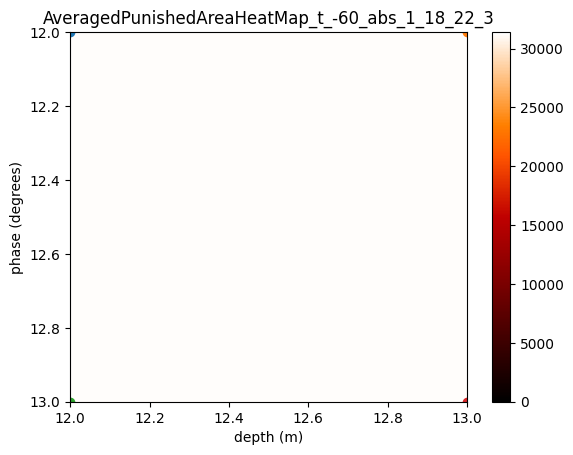

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from an abs threshold of -62 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


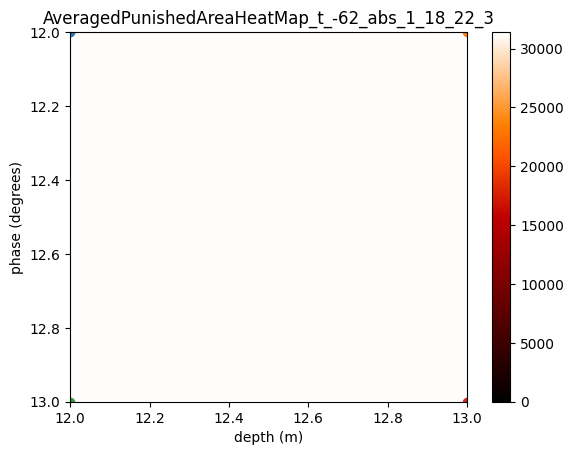

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from an abs threshold of -64 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


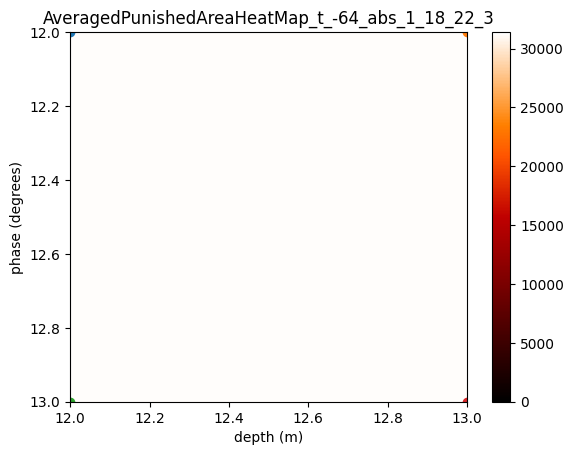

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from an abs threshold of -65 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


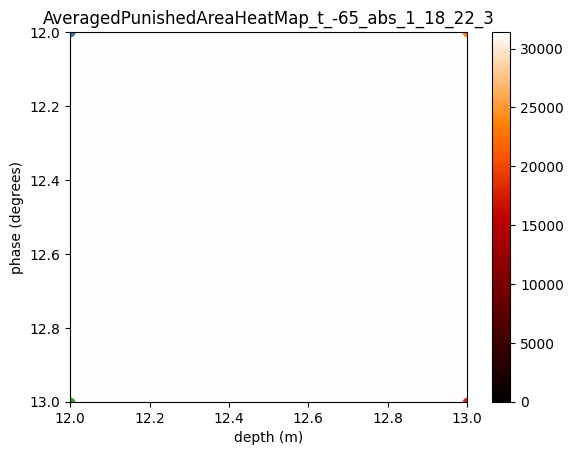

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from an abs threshold of -66 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


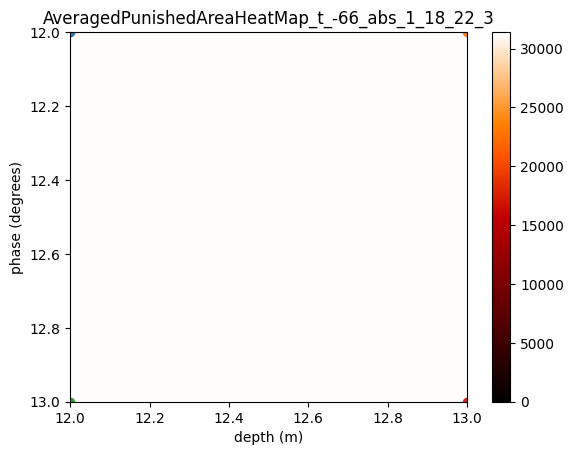

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from an abs threshold of -67 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


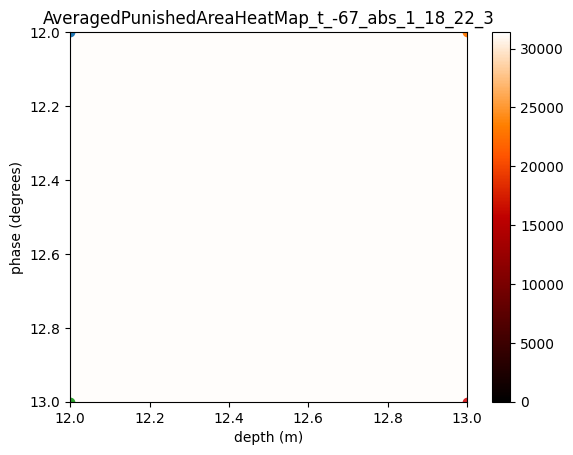

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from an abs threshold of -68 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


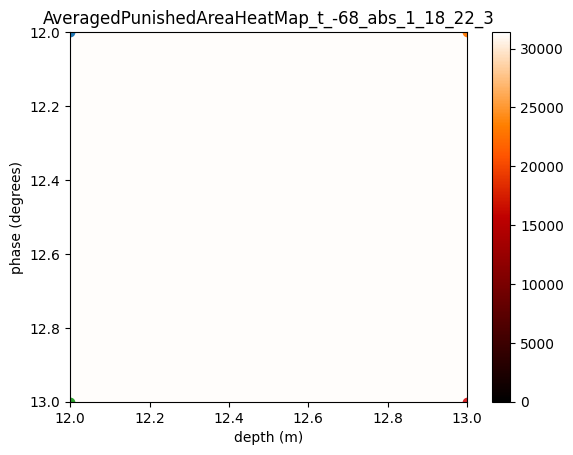

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from an abs threshold of -69 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


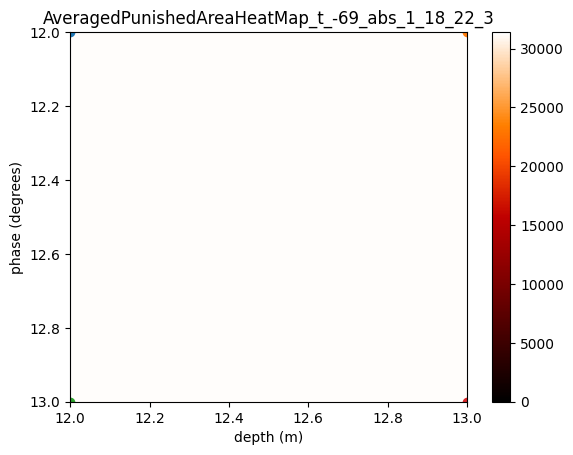

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from an abs threshold of -70 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


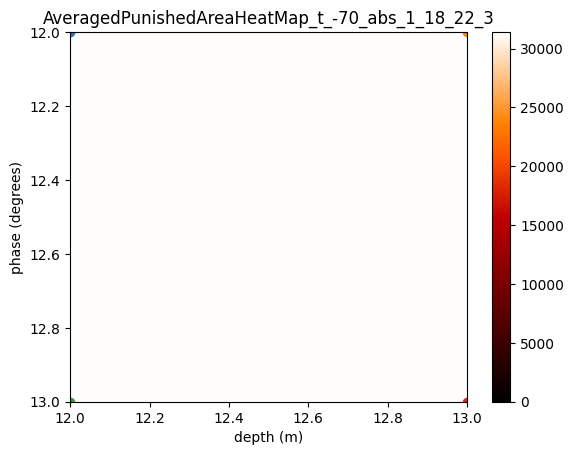

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from an abs threshold of -71 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


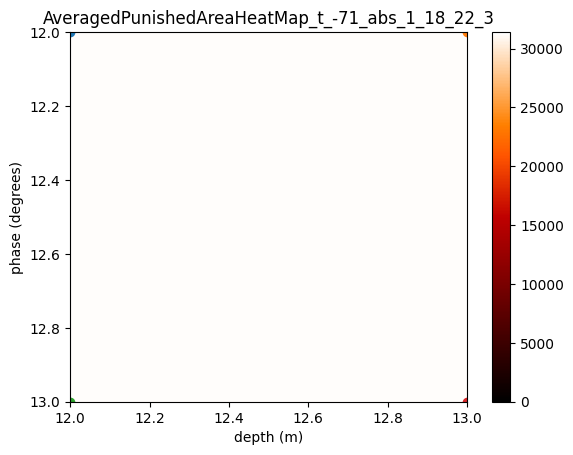

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from an abs threshold of -72 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


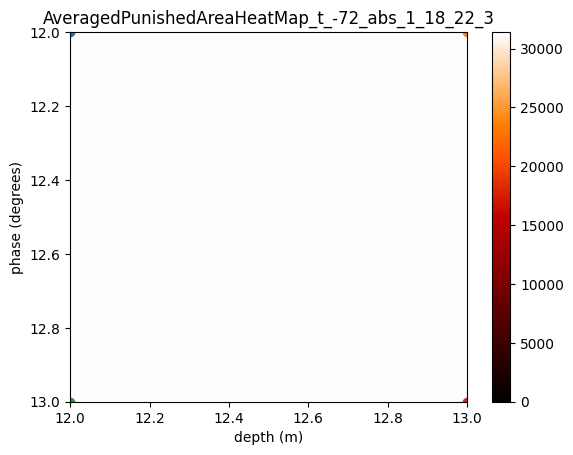

a = 100000
depth = 12.0
phi = 12
phi = 13
depth = 13.0
phi = 12
phi = 13
The best parameters from an abs threshold of -74 are 
 depth:[12, 13, 12, 13]
 phase:[12, 12, 13, 13]
 a:[100000, 100000, 100000, 100000]
 with an area of:[31258.84690321844, 31258.84690321844, 31258.84690321844, 31258.84690321844]


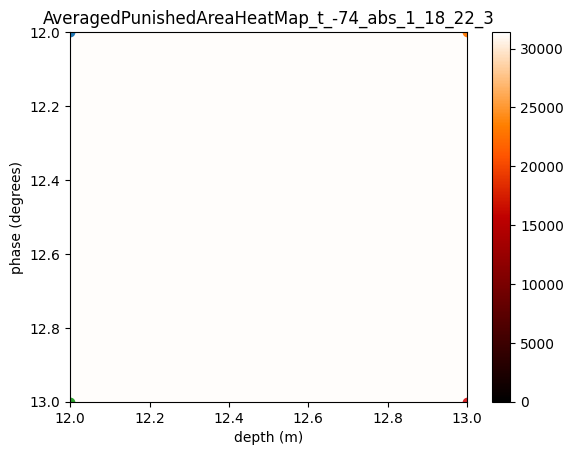

In [22]:
maxAveragedPunishedAbsarea = 0

for i in range(len(threshold_abss)):
    threshold_abs = threshold_abss[i]
    for a_i in range(len(a_array)):
        a = a_array[a_i]
        print("a = " + str(a))
        for d in range(len(depth_array)):
            depth_64 = depth_array[d]
            depth = float(depth_64)
            print("depth = " + str(depth))
            for p in range(len(phase_array)): 
                print("phi = " + str(phase_array[p]))
                phi = np.deg2rad(phase_array[p])

                #### calculate the area integral ####
                averaged_punished_area_integral_abs = 0
                for r_out_abs in range(column_size):
                    if r_out_abs < pixel_max:
                        if arrayESlices[p][d][a_i][r_out_abs] == 0:
                            arrayESlices[p][d][a_i][r_out_abs] = 0.0000000001
                        if threshold_abs < 10*math.log10((arrayESlices[p][d][a_i][r_out_abs])**2):
                            averaged_punished_area_integral_abs += r_out_abs*mpp*mpp

                averaged_punished_area_matrix_abs[p][d][a_i] = 2*np.pi*averaged_punished_area_integral_abs

                
    ### Finding the maximum area and the set(s) of parameters ###
    averaged_punished_area_abs_max = 0 
    maxAveragedPunishedAREAvaluesABS = []
    averaged_punished_area_phase_abs_max = 0
    averagedPunishedAreaMaxPHASEvaluesABS = []
    averaged_punished_area_depth_abs_max = 0
    averagedPunishedAreaMaxDEPTHvaluesABS = []
    averaged_punished_area_a_abs_max = 0
    averagedPunishedAreaMaxAvaluesABS = []
    for p in range(len(phase_array)):
        for d in range(len(depth_array)):
            for a in range(len(a_array)):
                if averaged_punished_area_abs_max <= averaged_punished_area_matrix_abs[p][d][a]:
                    maxAveragedPunishedAREAvaluesABS.append(averaged_punished_area_matrix_abs[p][d][a])
                    averaged_punished_area_abs_max = averaged_punished_area_matrix_abs[p][d][a]
                    averaged_punished_area_phase_abs_max = phase_array[p]
                    averagedPunishedAreaMaxPHASEvaluesABS.append(averaged_punished_area_phase_abs_max)
                    averaged_punished_area_depth_abs_max = depth_array[d]
                    averagedPunishedAreaMaxDEPTHvaluesABS.append(averaged_punished_area_depth_abs_max)
                    averaged_punished_area_a_abs_max = a_array[a]
                    averagedPunishedAreaMaxAvaluesABS.append(averaged_punished_area_a_abs_max)
     
    averaged_punished_area_indices_abs = []
    averagedPunishedAreaMaximizedAvaluesABS = []
    averagedPunishedAreaMaximizedDEPTHvaluesABS = []
    averagedPunishedAreaMaximizedPHASEvaluesABS = []
    averagedPunishedAreaMaximizedAREAvaluesABS = []
    
    biggest_averaged_punished_area_abs = max(maxAveragedPunishedAREAvaluesABS)

    for y in range(len(maxAveragedPunishedAREAvaluesABS)):
        if maxAveragedPunishedAREAvaluesABS[y] == biggest_averaged_punished_area_abs:
            averaged_punished_area_indices_abs.append(y)
    
    for z in averaged_punished_area_indices_abs:
        averagedPunishedAreaMaximizedAvaluesABS.append(averagedPunishedAreaMaxAvaluesABS[z])
        averagedPunishedAreaMaximizedDEPTHvaluesABS.append(averagedPunishedAreaMaxDEPTHvaluesABS[z])
        averagedPunishedAreaMaximizedPHASEvaluesABS.append(averagedPunishedAreaMaxPHASEvaluesABS[z])
        averagedPunishedAreaMaximizedAREAvaluesABS.append(maxAveragedPunishedAREAvaluesABS[z])    
    
    ## print the best set of parameters from a threshold to the optimized data file ##
    print('The best parameters from an abs threshold of ' + str(threshold_abs) + ' are \n depth:' + str(averagedPunishedAreaMaximizedDEPTHvaluesABS) + '\n phase:' + str(averagedPunishedAreaMaximizedPHASEvaluesABS) + 
          '\n a:' + str(averagedPunishedAreaMaximizedAvaluesABS) + '\n with an area of:' + str(averagedPunishedAreaMaximizedAREAvaluesABS))
    
    if biggest_averaged_punished_area_abs > maxAveragedPunishedAbsarea:
        maxAveragedPunishedAbsarea = biggest_averaged_punished_area_abs

        
    ## plot the heat map ##
    fig, ax = plt.subplots()
    ax.set_aspect('auto')
    averaged_punished_area_trans_abs = np.transpose(averaged_punished_area_matrix_abs)
    averaged_punished_area_heat_map_abs = np.transpose(averaged_punished_area_trans_abs[0])
    # add dots for best design #    
    for _ in range(len(averaged_punished_area_indices_abs)):
        plt.scatter(averagedPunishedAreaMaximizedDEPTHvaluesABS[_],averagedPunishedAreaMaximizedPHASEvaluesABS[_])
    plt.imshow(averaged_punished_area_heat_map_abs, extent=[depth_array[0],depth_array[-1],phase_array[-1],phase_array[0]], aspect = "auto", vmin=0, vmax=31400, interpolation='spline36', cmap='gist_heat', alpha=1)
    ax.set_xlabel("depth (m)")
    ax.set_ylabel("phase (degrees)")
    plt.axis('on')
    averaged_punished_area_plot_title_abs = "AveragedPunishedAreaHeatMap_t_"+str(threshold_abs)+"_abs_"+name
    plt.title(averaged_punished_area_plot_title_abs)
    plt.colorbar()
    plt.show()
    fig.savefig('ThresholdPlots/AveragedPunished/'+ averaged_punished_area_plot_title_abs +'.png') 
    
    
    ## write the best set of parameters from a threshold to the optimized data file ##
    for _ in range(len(averaged_punished_area_indices_abs)):
        file_averaged_punished_area_abs.write( "     " + str(threshold_abs) + "             " + str(averagedPunishedAreaMaximizedDEPTHvaluesABS[_]) + "          " + str(averagedPunishedAreaMaximizedPHASEvaluesABS[_]) + "          " + str(averagedPunishedAreaMaximizedAREAvaluesABS[_])  +'\n')
    
file_averaged_punished_area_abs.close()

In [23]:
### Creating a GIFs of all the heat maps from the various thresholds ###

from PIL import Image
import glob
 
# Create the frames
frames = []
imgs = glob.glob('ThresholdPlots/AveragedPunished/*abs_'+ name +'.png')
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 
# Save into a GIF file that loops forever
frames[0].save('ThresholdPlots/GIFs/AveragedPunishedAnimationAbs_'+name+'.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

# From here we will look at the analysis in .pdf